In [78]:
import seaborn as sns
import sdeint
import matplotlib.pyplot as plt
import pandas as pd
import sympy as smp
import random
import numpy as np
import pycatch22 as catch22
from metric_learn import MMC_Supervised
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.manifold import MDS
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.metrics import log_loss
from scipy.optimize import fsolve
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer, FunctionTransformer
from sklearn.model_selection import train_test_split, KFold
from sklearn.decomposition import PCA, FactorAnalysis
from time import perf_counter

# Test One - Chaotic Low Dimensional Discrete Maps

In [79]:
def gen_chirikovMap(mu, eta, N):
    """
    Generate a sample from the Chirikov map with parameters mu and eta
    """
    x_0 = np.random.uniform(low=0.01, high=0.1)
    y_0 = np.random.uniform(low=0.01, high=0.1)
    transient = 500
    x = np.zeros(N+transient)
    y = np.zeros(N+transient)
    x[0] = x_0
    y[0] = y_0
    for i in range(1, N+transient):
        y[i] = np.mod((y[i-1] + mu * np.sin(x[i-1])), 2*np.pi)
        x[i] = np.mod((x[i-1] + y[i]), 2*np.pi)

    return x[transient: ] + np.random.normal(0, eta, N)

In [80]:
def sample_chirikovMap(n_samples, N=None, eta=None, seed=2495):
    """
    Sample a Chirikov map with parameters mu and eta
    """
    np.random.seed(seed)
    if N is not None:
        N = np.repeat(N, n_samples)
    else:
        N = np.random.randint(50, 5000, size=n_samples)
    if eta is not None:
        eta = np.repeat(eta, n_samples)
    else:
        eta = np.random.uniform(0, 1, size=n_samples)
    mu = np.repeat(1, n_samples)
    ts = list()
    lengths = list()
    for i in range(n_samples):
        ts.append(gen_chirikovMap(mu[i], eta[i], N[i]))
        lengths.append(len(ts[i]))
    
    # feature extraction
    features = np.array([catch22.catch22_all(ts[i])['values'] for i in range(n_samples)])
    df = pd.DataFrame(features)
    df['N'] = lengths
    df['mu'] = mu
    df['eta'] = eta
    df['model'] = 'ChirikovMap'
    df['metaModel'] = 'ChaoticMap'

    return ts, df
    

In [81]:
def gen_logMap(mu, eta, N):
    """Generate time series from a logistic map of length N

    mu = control parameter

    eta = additive measurment noise parameter/variance value of error term
    """
    x_0 = np.random.uniform(low=0.01, high=0.1)
    transient = 500 # number of transient iterations to discard
    x = np.zeros(N+transient)
    x[0] = x_0
    for i in range(1, N+transient):
        x[i] = mu*x[i-1]*(1-x[i-1])

    return x[transient:] + np.random.normal(0, eta, N)

In [82]:
def gen_rickersMap(mu, eta, N):
    """Generate a sample from the Ricker's population map with parameters mu and eta"""
    x_0 = np.random.uniform(low=0.01, high=0.1)
    transient = 500
    x = np.zeros(N+transient)
    x[0] = x_0
    for i in range(1, N+transient):
        x[i] = mu * x[i-1] * np.exp(-x[i-1])
    
    return x[transient: ] + np.random.normal(0, eta, N)

In [83]:
def sample_rickersMap(n_samples, N=None, eta=None, seed=9855):
    """
    Sample a Ricker's map with parameters mu and eta
    """
    np.random.seed(seed)
    if N is not None:
        N = np.repeat(N, n_samples)
    else:
        N = np.random.randint(50, 5000, size=n_samples)
    if eta is not None:
        eta = np.repeat(eta, n_samples)
    else:
        eta = np.random.uniform(0, 1, size=n_samples)
    mu = np.repeat(20, n_samples)
    ts = list()
    lengths = list()
    for i in range(n_samples):
        ts.append(gen_rickersMap(mu[i], eta[i], N[i]))
        lengths.append(len(ts[i]))
    
    # feature extraction
    features = np.array([catch22.catch22_all(ts[i])['values'] for i in range(n_samples)])
    df = pd.DataFrame(features)
    df['N'] = lengths
    df['mu'] = mu
    df['eta'] = eta
    df['model'] = 'RickersMap'
    df['metaModel'] = 'ChaoticMap'

    return ts, df

In [84]:
def sample_logMap(n_samples, N=None, eta=None, seed=42):
    """Generate chaotic time series from the logistic map
    Samples are generated from the range mu = [3.57, 4]
    """
    np.random.seed(seed)
    if N is not None:
        N = np.repeat(N, n_samples)
    else:
        N = np.random.randint(50, 5000, n_samples)
    if eta is not None:
        eta = np.repeat(eta, n_samples)
    else:
        eta = np.random.uniform(0, 1, n_samples)
    mu = np.random.uniform(low=3.57, high=4, size=n_samples)
    sols = list()
    lengths_store = list()
    for i in range(n_samples):
        sols.append(gen_logMap(mu[i], eta[i], N[i]))
        lengths_store.append(len(sols[i]))
    
    # feature extraction
    features = np.array([catch22.catch22_all(sols[i])['values'] for i in range(n_samples)])
    ts = sols
    df = pd.DataFrame(features)
    df['N'] = lengths_store
    df['mu'] = mu
    df['eta'] = eta
    df['model'] = 'LogMap'
    df['metaModel'] = 'ChaoticMap'

    
    return ts, df

In [85]:
def gen_tentMap(mu, eta, N):
    """Generate time series from a tent map of length N

    mu = control parameter

    eta = additive measurment noise parameter/variance value of error term
    """
    x_0 = np.random.uniform(low=0.01, high=0.1)
    transient = 500 # number of transient iterations to discard
    x = np.zeros(N+transient)
    x[0] = x_0
    for i in range(1, N+transient):
        x[i] = mu*min(x[i-1], 1-x[i-1])

    return x[transient:] + np.random.normal(0, eta, N)

In [86]:
def sample_tentMap(n_samples, N=None, eta=None, seed=2445):
    """Generate chaotic time series from the tent map
    Samples are generated from the range mu = (1.15, 2]
    """
    np.random.seed(seed)
    if N is not None:
        N = np.repeat(N, n_samples)
    else:
        N = np.random.randint(50, 5000, n_samples)
    if eta is not None:
        eta = np.repeat(eta, n_samples)
    else:
        eta = np.random.uniform(0, 1, n_samples)
    mu = np.random.uniform(low=1.15, high=2, size=n_samples)
    sols = list()
    lengths_store = list()
    for i in range(n_samples):
        sols.append(gen_tentMap(mu[i], eta[i], N[i]))
        lengths_store.append(len(sols[i]))
    
    # feature extraction
    features = np.array([catch22.catch22_all(sols[i])['values'] for i in range(n_samples)])
    ts = sols
    df = pd.DataFrame(features)
    df['N'] = lengths_store
    df['mu'] = mu
    df['eta'] = eta
    df['model'] = 'TentMap'
    df['metaModel'] = 'ChaoticMap'

    
    return ts, df

In [87]:
def gen_henonMap(mu, eta, N):
    """Generate time series from a Sine map of length N

    mu = control parameter

    b = 0.3 by default as per literature values, a (mu) is the control parameter of interest
    
    eta = additive measurment noise parameter/variance value of error term
    """
    x_0 = np.random.uniform(low=0.01, high=0.1)
    y_0 = np.random.uniform(low=0.01, high=0.1)
    transient = 500 # number of transient iterations to discard
    x = np.zeros(N+transient)
    y = np.zeros(N+transient)

    x[0] = x_0
    y[0] = y_0

    for i in range(1, N+transient):
        x[i] = 1 - mu * x[i-1]**2 + y[i-1]
        y[i] = 0.3 * x[i-1]

    return x[transient:] + np.random.normal(0, eta, N)

In [88]:
def sample_henonMap(n_samples, N=None, eta=None, seed=955):
    """Generate chaotic time series from the Henon map
    Samples are generated from the range mu = [1.05, 1.4)
    """
    np.random.seed(seed)
    if N is not None:
        N = np.repeat(N, n_samples)
    else:
        N = np.random.randint(50, 5000, n_samples)
    if eta is not None:
        eta = np.repeat(eta, n_samples)
    else:
        eta = np.random.uniform(0, 1, n_samples)
    mu = np.random.uniform(low=1.05, high=1.4, size=n_samples)
    sols = list()
    lengths_store = list()
    for i in range(n_samples):
        sols.append(gen_henonMap(mu[i], eta[i], N[i]))
        lengths_store.append(len(sols[i]))
    
    # feature extraction
    features = np.array([catch22.catch22_all(sols[i])['values'] for i in range(n_samples)])
    ts = sols
    df = pd.DataFrame(features)
    df['N'] = lengths_store
    df['mu'] = mu
    df['eta'] = eta
    df['model'] = 'HenonMap'
    df['metaModel'] = 'ChaoticMap'

    
    return ts, df

In [89]:
def gen_ikdeaMap(mu, eta, N):
    """Generate time series from an ikdea map of length N

    mu = control parameter

    eta = additive measurment noise parameter/variance value of error term
    """
    x_0 = np.random.uniform(low=0.01, high=0.1)
    y_0 = np.random.uniform(low=0.01, high=0.1)
    transient = 500 # number of transient iterations to discard
    x = np.zeros(N+transient)
    y = np.zeros(N+transient)

    x[0] = x_0
    y[0] = y_0
    for i in range(1, N+transient):
        theta = 0.4 - 6 / (1 + x[i-1]**2 + y[i-1]**2)
        x[i] = 1 + mu * (x[i-1] * np.cos(theta) - y[i-1] * np.sin(theta))
        y[i] = mu * (x[i-1] * np.sin(theta) + y[i-1] * np.cos(theta))

    return x[transient:] + np.random.normal(0, eta, N)

In [90]:
def sample_ikdeaMap(n_samples, N=None, eta=None, seed=565):
    """Generate chaotic time series from the ikdea map
    Samples are generated from the range mu = [0.65, 0.9)
    """
    np.random.seed(seed)
    if N is not None:
        N = np.repeat(N, n_samples)
    else:
        N = np.random.randint(50, 5000, n_samples)
    if eta is not None:
        eta = np.repeat(eta, n_samples)
    else:
        eta = np.random.uniform(0, 1, n_samples)
    mu = np.random.uniform(low=.65, high=0.9, size=n_samples)
    sols = list()
    lengths_store = list()
    for i in range(n_samples):
        sols.append(gen_ikdeaMap(mu[i], eta[i], N[i]))
        lengths_store.append(len(sols[i]))
    
    # feature extraction
    features = np.array([catch22.catch22_all(sols[i])['values'] for i in range(n_samples)])
    ts = sols
    df = pd.DataFrame(features)
    df['N'] = lengths_store
    df['mu'] = mu
    df['eta'] = eta
    df['model'] = 'IkdeaMap'
    df['metaModel'] = 'ChaoticMap'

    
    return ts, df

In [91]:
def gen_tinkerbellMap(mu, eta, N):
    """Generate time series from a tinkerbell map of length N

    mu = control parameter (a)

    literture values:
    b = -0.6
    c = 2.0
    d = 0.5
    
    eta = additive measurment noise parameter/variance value of error term
    """
    x_0 = np.random.uniform(low=0.01, high=0.1)
    y_0 = np.random.uniform(low=0.01, high=0.1)
    transient = 500 # number of transient iterations to discard
    x = np.zeros(N+transient)
    y = np.zeros(N+transient)

    b = -0.6
    c = 2.0
    d = 0.5

    x[0] = x_0
    y[0] = y_0

    for i in range(1, N+transient):
        x[i] = x[i-1]**2 - y[i-1]**2 + mu * x[i-1] + b * y[i-1]
        y[i] = 2 * x[i-1] * y[i-1] + c * x[i-1] + d * y[i-1]

    return x[transient:] + np.random.normal(0, eta, N)

In [92]:
def sample_tinkerbellMap(n_samples, N=None, eta=None, seed=215):
    """Generate chaotic time series from the tinkerbell map
    Samples are generated from mu = 0.9 as per literature values
    """
    np.random.seed(seed)
    if N is not None:
        N = np.repeat(N, n_samples)
    else:
        N = np.random.randint(50, 5000, n_samples)
    if eta is not None:
        eta = np.repeat(eta, n_samples)
    else:
        eta = np.random.uniform(0, 1, n_samples)
    mu = np.repeat(0.9, n_samples)
    sols = list()
    lengths_store = list()
    for i in range(n_samples):
        sols.append(gen_tinkerbellMap(mu[i], eta[i], N[i]))
        lengths_store.append(len(sols[i]))
    
    # feature extraction
    features = np.array([catch22.catch22_all(sols[i])['values'] for i in range(n_samples)])
    ts = sols
    df = pd.DataFrame(features)
    df['N'] = lengths_store
    df['mu'] = mu
    df['eta'] = eta
    df['model'] = 'TinkerbellMap'
    df['metaModel'] = 'ChaoticMap'

    
    return ts, df

In [93]:
def gen_burgersMap(mu, eta, N):
    """Generate time series from a Burger's map of length N

    mu = control parameter (b)

    literture values:
    a = 0.75
    b = 1.75
    
    eta = additive measurment noise parameter/variance value of error term
    """
    x_0 = np.random.uniform(low=0.01, high=0.1)
    y_0 = np.random.uniform(low=0.01, high=0.1)
    transient = 500 # number of transient iterations to discard
    x = np.zeros(N+transient)
    y = np.zeros(N+transient)

    a = 0.75

    x[0] = x_0
    y[0] = y_0

    for i in range(1, N+transient):
        x[i] = a * x[i-1] - y[i-1]**2
        y[i] = mu * y[i-1] + x[i-1] * y[i-1]

    return x[transient:] + np.random.normal(0, eta, N)

In [94]:
def sample_burgersMap(n_samples, N=None, eta=None, seed=13):
    """Generate chaotic time series from the Burger's map
    Samples are generated from mu = 1.75 as per literature values
    """
    np.random.seed(seed)
    if N is not None:
        N = np.repeat(N, n_samples)
    else:
        N = np.random.randint(50, 5000, n_samples)
    if eta is not None:
        eta = np.repeat(eta, n_samples)
    else:
        eta = np.random.uniform(0, 1, n_samples)
    mu = np.repeat(1.75, n_samples)
    sols = list()
    lengths_store = list()
    for i in range(n_samples):
        sols.append(gen_burgersMap(mu[i], eta[i], N[i]))
        lengths_store.append(len(sols[i]))
    
    # feature extraction
    features = np.array([catch22.catch22_all(sols[i])['values'] for i in range(n_samples)])
    ts = sols
    df = pd.DataFrame(features)
    df['N'] = lengths_store
    df['mu'] = mu
    df['eta'] = eta
    df['model'] = 'BurgersMap'
    df['metaModel'] = 'ChaoticMap'

    
    return ts, df

In [95]:
def gen_pinchersMap(mu, eta, N):
    """Generate time series from a Pincher's map of length N

    mu = control parameter (s)

    literture values:
    s = 1.6
    c = 0.5
    
    eta = additive measurment noise parameter/variance value of error term
    """
    x_0 = np.random.uniform(low=0.01, high=0.1)
    transient = 500 # number of transient iterations to discard
    x = np.zeros(N+transient)
    x[0] = x_0

    c = 0.5 

    for i in range(1, N+transient):
        x[i] = np.abs(np.tanh(mu * (x[i-1] - c)))

    return x[transient:] + np.random.normal(0, eta, N)

In [96]:
def sample_pinchersMap(n_samples, N=None, eta=None, seed=291):
    """Generate chaotic time series from the Pincher's map
    Samples are generated from mu = 1.6 as per literature values
    """
    np.random.seed(seed)
    if N is not None:
        N = np.repeat(N, n_samples)
    else:
        N = np.random.randint(50, 5000, n_samples)
    if eta is not None:
        eta = np.repeat(eta, n_samples)
    else:
        eta = np.random.uniform(0, 1, n_samples)
    mu = np.repeat(1.6, n_samples)
    sols = list()
    lengths_store = list()
    for i in range(n_samples):
        sols.append(gen_pinchersMap(mu[i], eta[i], N[i]))
        lengths_store.append(len(sols[i]))
    
    # feature extraction
    features = np.array([catch22.catch22_all(sols[i])['values'] for i in range(n_samples)])
    ts = sols
    df = pd.DataFrame(features)
    df['N'] = lengths_store
    df['mu'] = mu
    df['eta'] = eta
    df['model'] = 'PinchersMap'
    df['metaModel'] = 'ChaoticMap'

    
    return ts, df

In [97]:
def gen_cuspMap(mu, eta, N):
    """Generate time series from a Cusp map of length N

    mu = control parameter (a)

    literture values:
    a = 1.2   
    eta = additive measurment noise parameter/variance value of error term
    """
    x_0 = np.random.uniform(low=0.01, high=0.1)
    transient = 500 # number of transient iterations to discard
    x = np.zeros(N+transient)
    x[0] = x_0
    for i in range(1, N+transient):
        x[i] = 1 - mu * np.sqrt(np.abs(x[i-1]))

    return x[transient:] + np.random.normal(0, eta, N)

In [98]:
def sample_cuspMap(n_samples, N=None, eta=None, seed=1234):
    """Generate chaotic time series from the Cusp map
    Samples are generated from mu = 1.2 as per literature values
    """
    np.random.seed(seed)
    if N is not None:
        N = np.repeat(N, n_samples)
    else:
        N = np.random.randint(50, 5000, n_samples)
    if eta is not None:
        eta = np.repeat(eta, n_samples)
    else:
        eta = np.random.uniform(0, 1, n_samples)
    mu = np.repeat(1.2, n_samples)
    sols = list()
    lengths_store = list()
    for i in range(n_samples):
        sols.append(gen_cuspMap(mu[i], eta[i], N[i]))
        lengths_store.append(len(sols[i]))
    
    # feature extraction
    features = np.array([catch22.catch22_all(sols[i])['values'] for i in range(n_samples)])
    ts = sols
    df = pd.DataFrame(features)
    df['N'] = lengths_store
    df['mu'] = mu
    df['eta'] = eta
    df['model'] = 'CuspMap'
    df['metaModel'] = 'ChaoticMap'

    
    return ts, df

In [99]:
def gen_sinaiMap(mu, eta, N):
    """Generate a sample from a Sinai map of length N

    mu = control parameter (a)

    literture values:
    delta = 0.10   
    eta = additive measurment noise parameter/variance value of error term
    """
    x_0 = np.random.uniform(low=0.01, high=0.1)
    y_0 = np.random.uniform(low=0.01, high=0.1)
    transient = 500 # number of transient iterations to discard
    x = np.zeros(N+transient)
    y = np.zeros(N+transient)
    x[0] = x_0
    y[0] = y_0
    for i in range(1, N+transient):
        x[i] = np.mod((x[i-1] + y[i-1] + mu * np.cos(2*np.pi * y[i-1])), 1)
        y[i] = np.mod((x[i-1] + 2 * y[i-1]), 1)
    
    return x[transient:] + np.random.normal(0, eta, N)

In [100]:
def sample_sinaiMap(n_samples, N=None, eta=None, seed=83344):
    """Generate chaotic time series from the Sinai map
    Samples are generated from mu = 0.10 as per literature values
    """
    np.random.seed(seed)
    if N is not None:
        N = np.repeat(N, n_samples)
    else:
        N = np.random.randint(50, 5000, n_samples)
    if eta is not None:
        eta = np.repeat(eta, n_samples)
    else:
        eta = np.random.uniform(0, 1, n_samples)
    mu = np.repeat(0.10, n_samples)
    sols = list()
    lengths_store = list()
    for i in range(n_samples):
        sols.append(gen_sinaiMap(mu[i], eta[i], N[i]))
        lengths_store.append(len(sols[i]))
    
    # feature extraction
    features = np.array([catch22.catch22_all(sols[i])['values'] for i in range(n_samples)])
    ts = sols
    df = pd.DataFrame(features)
    df['N'] = lengths_store
    df['mu'] = mu
    df['eta'] = eta
    df['model'] = 'SinaiMap'
    df['metaModel'] = 'ChaoticMap'

    
    return ts, df

In [101]:
def sample_Maps(samples_per_map, N=None, eta=None):
    """Sample the joint space of chaotic maps"""
    ts1, df1 = sample_henonMap(samples_per_map, N=N, eta=eta)
    ts2, df2 = sample_tinkerbellMap(samples_per_map, N=N, eta=eta)
    ts3, df3 = sample_burgersMap(samples_per_map, N=N, eta=eta)
    ts4, df4 = sample_pinchersMap(samples_per_map, N=N, eta=eta)
    ts5, df5 = sample_logMap(samples_per_map, N=N, eta=eta)
    ts6, df6 = sample_ikdeaMap(samples_per_map, N=N, eta=eta)
    ts7, df7 = sample_tentMap(samples_per_map, N=N, eta=eta)
    ts8, df8 = sample_cuspMap(samples_per_map, N=N, eta=eta)
    ts9, df9 = sample_sinaiMap(samples_per_map, N=N, eta=eta)
    ts10, df10 = sample_rickersMap(samples_per_map, N=N, eta=eta)
    ts11, df11 = sample_chirikovMap(samples_per_map, N=N, eta=eta)
    ts = ts1 + ts2 + ts3 + ts4 + ts5 + ts6 + ts7 + ts8 + ts9 + ts10 + ts11
    df = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11], axis=0, ignore_index=True)
    return ts, df

## Scenario 1: No noise, Fixed Time Series Length (N=5000)

In [102]:
ts, x = sample_Maps(300, N=5000, eta=0)

In [103]:
rs = RobustScaler().fit(x.iloc[:,:22])
rs_transformed = rs.transform(x.iloc[:,:22])
def sigmoid(x, theta):
    return 1/(1+np.exp(-theta*x))
sig = FunctionTransformer(sigmoid, kw_args={'theta': 1.35})
sig_transformed = sig.transform(rs_transformed)
mm = MinMaxScaler().fit(sig_transformed)
mm_transformed = mm.transform(sig_transformed)
xhat = mm_transformed

In [104]:
pca = PCA(n_components=2).fit(xhat)
xhat_pca = pca.transform(xhat)

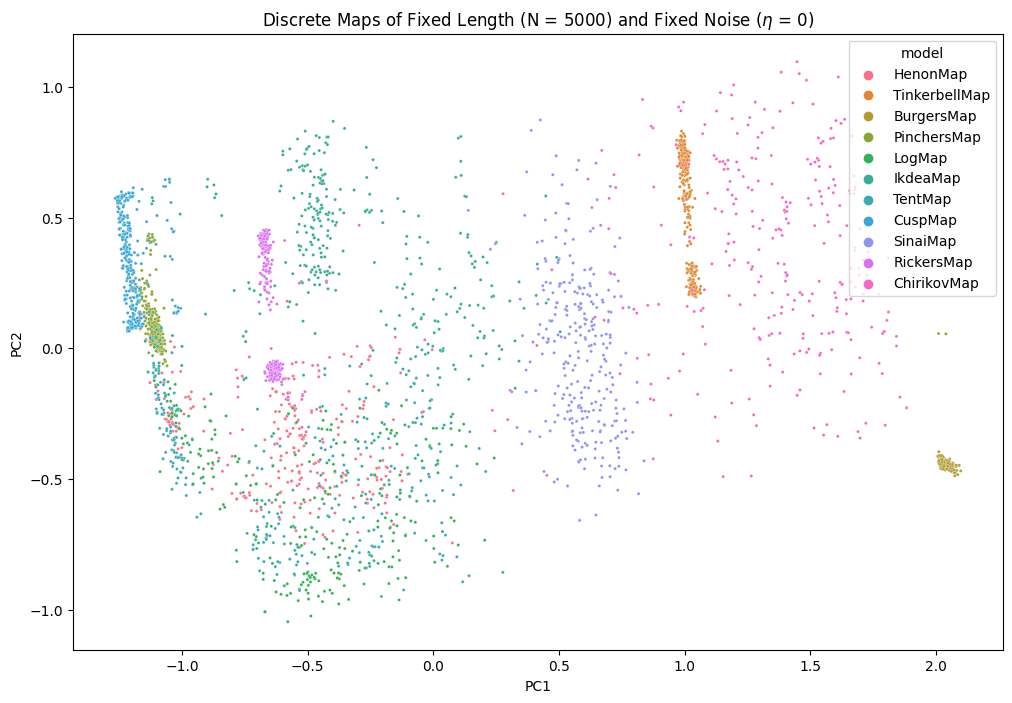

In [105]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x=xhat_pca[:, 0], y=xhat_pca[:, 1], hue=x['model'], s=5)
plt.title('Discrete Maps of Fixed Length (N = 5000) and Fixed Noise ($\eta$ = 0)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

The ideal case. Note the overlap between Henon, Log and Tent Map in particular. An interesting point is that all three maps have topologically similar bifurcation structures which may be responsible for producing qualitatively similar dynamics. 

## Scenario 2: No noise, Short Time Series Length (N=50)

In [106]:
ts, x = sample_Maps(300, N=50, eta=0)

In [107]:
rs = RobustScaler().fit(x.iloc[:,:22])
rs_transformed = rs.transform(x.iloc[:,:22])
def sigmoid(x, theta):
    return 1/(1+np.exp(-theta*x))
sig = FunctionTransformer(sigmoid, kw_args={'theta': 1.35})
sig_transformed = sig.transform(rs_transformed)
mm = MinMaxScaler().fit(sig_transformed)
mm_transformed = mm.transform(sig_transformed)
xhat = mm_transformed

In [108]:
pca = PCA(n_components=2).fit(xhat)
xhat_pca = pca.transform(xhat)

Text(0, 0.5, 'PC2')

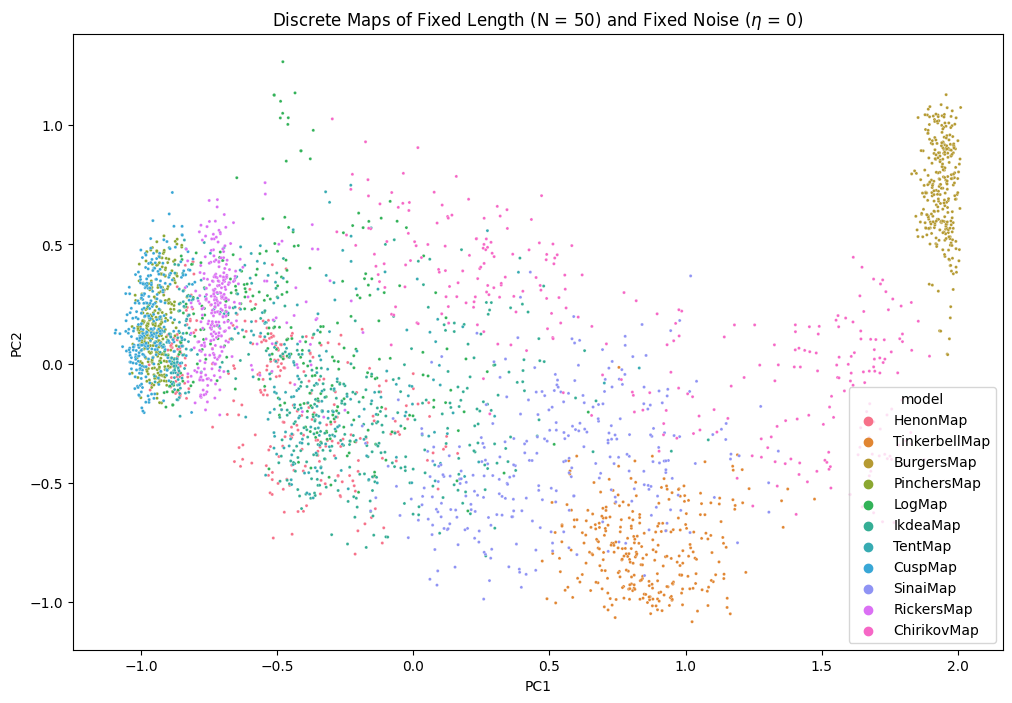

In [109]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x=xhat_pca[:, 0], y=xhat_pca[:, 1], hue=x['model'], s=5)
plt.title('Discrete Maps of Fixed Length (N = 50) and Fixed Noise ($\eta$ = 0)')
plt.xlabel('PC1')
plt.ylabel('PC2')

## Scenario 3: Uniform sampling over N and eta

In [110]:
ts, x = sample_Maps(300)

In [111]:
rs = RobustScaler().fit(x.iloc[:,:22])
rs_transformed = rs.transform(x.iloc[:,:22])
def sigmoid(x, theta):
    return 1/(1+np.exp(-theta*x))
sig = FunctionTransformer(sigmoid, kw_args={'theta': 1.35})
sig_transformed = sig.transform(rs_transformed)
mm = MinMaxScaler().fit(sig_transformed)
mm_transformed = mm.transform(sig_transformed)
xhat = mm_transformed
pca = PCA(n_components=2).fit(xhat)
xhat_pca = pca.transform(xhat)

Text(0, 0.5, 'PC2')

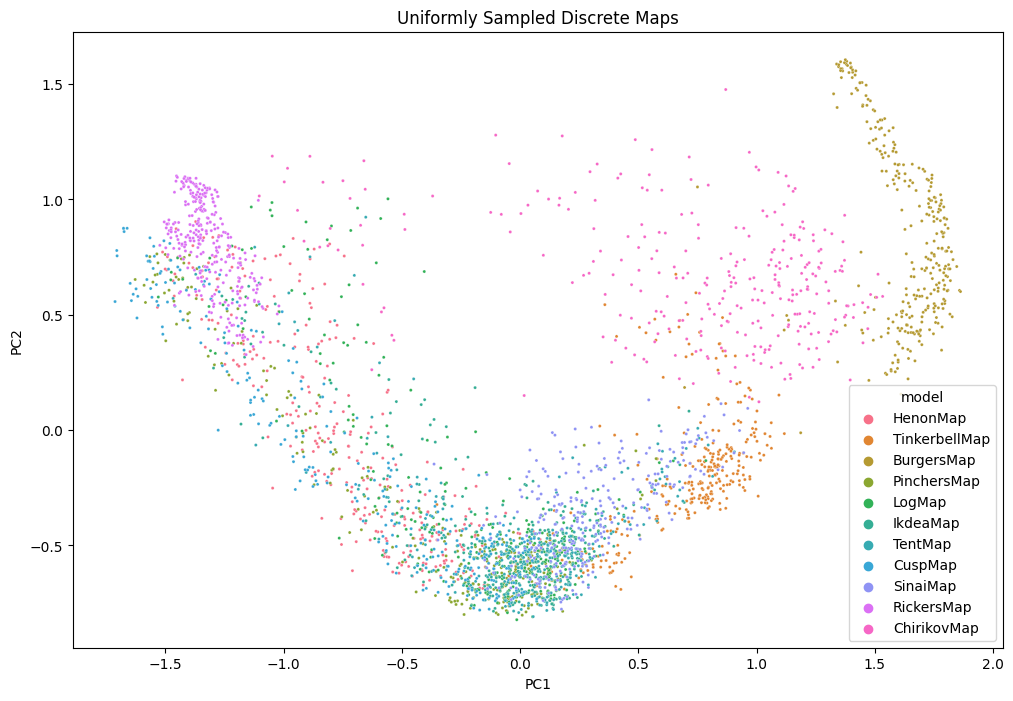

In [112]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x=xhat_pca[:, 0], y=xhat_pca[:, 1], hue=x['model'], s=5)
plt.title('Uniformly Sampled Discrete Maps')
plt.xlabel('PC1')
plt.ylabel('PC2')

Implement metric learning to optimise the space

In [113]:
le = LabelEncoder().fit(x['model'])
y = le.transform(x['model'])

In [114]:
mmc = MMC_Supervised(random_state=245)
mmc_fit = mmc.fit(xhat, y)
X_mmc = mmc_fit.transform(xhat)
learned_metric = mmc.get_metric()

Visualisations using various linear and nonlinear transformations

In [115]:
pca_opt = MDS(n_components=2).fit_transform(X_mmc)
X_mmc_pca = pca_opt.transform(X_mmc)

AttributeError: 'numpy.ndarray' object has no attribute 'transform'

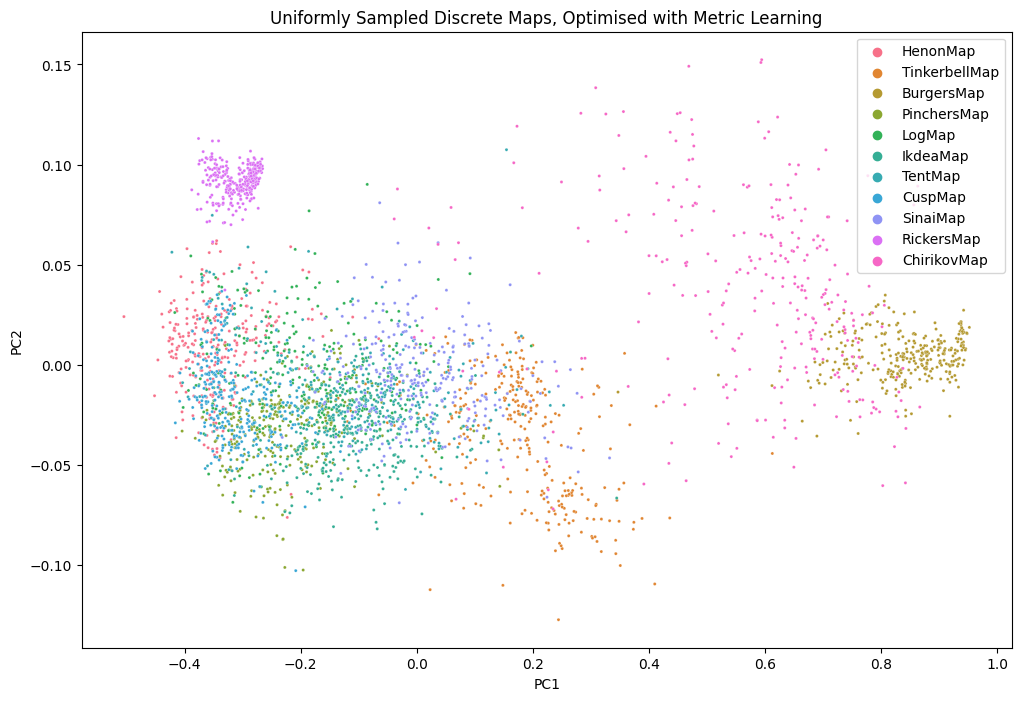

In [ ]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_mmc_pca[:, 0], y=X_mmc_pca[:, 1], hue=le.inverse_transform(y), s=5)
plt.title('Uniformly Sampled Discrete Maps, Optimised with Metric Learning')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

Construct an evaluation test

## Test Two - Meta-models: Chaotic Maps vs Stochastic Processes

Idea: clobber together all of the chaotic maps into one 'meta-model' and compare it to non-chaotic scenarios for very high level inference. This is to be contrasted with lower levels of inference such as discriminating between individual maps.

In [116]:
def gen_gaussianNoise(sigma, N):
    """Generate Gaussian noise"""
    return np.random.normal(0, sigma, N)

In [117]:
def sample_gaussianNoise(n_samples, N=None, sigma=None):
    """Sample from Gaussian noise"""
    if N is not None:
        N = np.repeat(N, n_samples)
    else:
        N = np.random.randint(50, 5000, n_samples)
    if sigma is not None:
        sigma = np.repeat(sigma, n_samples)
    else:
        sigma = np.random.uniform(0, 1, n_samples)
    ts = list()
    lengths = list()
    for i in range(n_samples):
        ts.append(gen_gaussianNoise(sigma[i], N[i]))
        lengths.append(len(ts[i]))
    
    features = np.array([catch22.catch22_all(ts[i])['values'] for i in range(n_samples)])
    df = pd.DataFrame(features)
    df['N'] = lengths
    df['model'] = 'GaussianNoise'
    df['metaModel'] = 'StochasticProcess'

    return ts, df

In [118]:
def gen_uniformNoise(N):
    """Generate Uniform noise"""
    return np.random.uniform(size=N)

In [119]:
def sample_uniformNoise(n_samples, N=None):
    """Sample from Uniform noise"""
    if N is not None:
        N = np.repeat(N, n_samples)
    else:
        N = np.random.randint(50, 5000, n_samples)
    ts = list()
    lengths = list()
    for i in range(n_samples):
        ts.append(gen_uniformNoise(N[i]))
        lengths.append(len(ts[i]))
    
    features = np.array([catch22.catch22_all(ts[i])['values'] for i in range(n_samples)])
    df = pd.DataFrame(features)
    df['N'] = lengths
    df['model'] = 'UniformNoise'
    df['metaModel'] = 'StochasticProcess'

    return ts, df

In [120]:
def gen_cauchyNoise(N):
    """Generate Cauchy noise"""
    return np.random.standard_cauchy(N)

In [121]:
def sample_cauchyNoise(n_samples, N=None):
    """Sample from Cauchy distribution"""
    if N is not None:
        N = np.repeat(N, n_samples)
    else:
        N = np.random.randint(50, 5000, n_samples)
    ts = list()
    lengths = list()
    for i in range(n_samples):
        ts.append(gen_cauchyNoise(N[i]))
        lengths.append(len(ts[i]))
    
    features = np.array([catch22.catch22_all(ts[i])['values'] for i in range(n_samples)])
    df = pd.DataFrame(features)
    df['N'] = lengths
    df['model'] = 'CauchyNoise'
    df['metaModel'] = 'StochasticProcess'

    return ts, df

In [122]:
def gen_expNoise(lam, N):
    """Generate Exponential noise"""
    return np.random.exponential(scale=lam, size=N)

In [123]:
def sample_expNoise(n_samples, N=None, lam=None):
    """Sample from Exponential distribution"""
    if N is not None:
        N = np.repeat(N, n_samples)
    else:
        N = np.random.randint(50, 5000, n_samples)
    if lam is not None:
        lam = np.repeat(lam, n_samples)
    else:
        lam = np.random.uniform(0, 1, n_samples)
    ts = list()
    lengths = list()
    for i in range(n_samples):
        ts.append(gen_expNoise(lam[i], N[i]))
        lengths.append(len(ts[i]))
    
    features = np.array([catch22.catch22_all(ts[i])['values'] for i in range(n_samples)])
    df = pd.DataFrame(features)
    df['N'] = lengths
    df['model'] = 'ExpNoise'
    df['metaModel'] = 'StochasticProcess'

    return ts, df

In [124]:
def gen_AR1(phi, sigma, N):
    """Generate an AR1 process

    Parameters
    ----------
    phi : float
        Autoregressive parameter
    sigma : float
        Standard deviation of the noise
    N : int
        Number of samples
    """
    x_0 = np.random.normal()
    transient = 500
    x = np.zeros(N+transient)
    x[0] = x_0
    for i in range(1, N+transient):
        x[i] = phi * x[i-1] + sigma * np.random.normal()
    return x[transient:]

In [125]:
def sample_AR1(n_samples, N=None, eta=None, seed=4576):
    """Sample AR(1) time series of length N

    Args:
        n_samples (int): number of samples to generate
        N (int): length of time series
        eta (float): noise level (sigma)
        seed (int): random seed for reproducing results
    
    Returns:
        ts (list): list of time series
        df (pd.DataFrame): dataframe of time series
    """
    np.random.seed(seed)
    if N is not None:
        N = np.repeat(N, n_samples)
    else:
        N = np.random.randint(50, 5000, n_samples)
    if eta is not None:
        eta = np.repeat(eta, n_samples)
    else:
        eta = np.random.uniform(0, 1, n_samples)
    phi = np.random.uniform(-0.99, 1, n_samples)
    ts = list()
    lengths = list()
    for i in range(n_samples):
        ts.append(gen_AR1(phi[i], eta[i], N[i]))
        lengths.append(len(ts[i]))
    
    features = np.array([catch22.catch22_all(ts[i])['values'] for i in range(n_samples)])
    df = pd.DataFrame(features)
    df['N'] = lengths
    df['eta'] = eta
    df['phi'] = phi
    df['system'] = 'AR1'

    return ts, df
    

In [126]:
def gen_AR2(phi1, phi2, sigma, N):
    """Generate an AR2 process

    Parameters
    ----------
    phi1 : float
        Autoregressive parameter 1
    phi2 : float
        Autoregressive parameter 2
    sigma : float
        Standard deviation of the noise
    N : int
        Number of samples
    """
    x_0 = np.random.normal()
    x_1 = np.random.normal()
    transient = 500
    x = np.zeros(N+transient)
    x[0] = x_0
    x[1] = x_1
    for i in range(2, N+transient):
        x[i] = phi1 * x[i-1] + phi2 * x[i-2] + sigma * np.random.normal()
    return x[transient:]

In [127]:
def sample_AR2(n_samples, N=None, eta=None, seed=34856):
    """Sample AR(2) time series of length N

    Args:
        n_samples (int): number of samples to generate
        N (int): length of time series
        eta (float): noise level (sigma)
        seed (int): random seed for reproducing results
    
    Returns:
        ts (list): list of time series
        df (pd.DataFrame): dataframe of time series
    """
    np.random.seed(seed)
    if N is not None:
        N = np.repeat(N, n_samples)
    else:
        N = np.random.randint(50, 5000, n_samples)
    if eta is not None:
        eta = np.repeat(eta, n_samples)
    else:
        eta = np.random.uniform(0, 1, n_samples)

    # AR(2) is stationary if phi1 + phi2 < 1 and phi2 - phi1 < 1 and |phi2| < 1
    phi1_store = list()
    phi2_store = list()
    ts = list()
    lengths = list()
    count = 0
    while count < n_samples:
        phi1 = np.random.uniform(-0.99, 1)
        phi2 = np.random.uniform(-0.99, 1)
        if phi1 + phi2 < 1 and phi2 - phi1 < 1 and abs(phi2) < 1:
            phi1_store.append(phi1)
            phi2_store.append(phi2)
            ts.append(gen_AR2(phi1, phi2, eta[count], N[count]))
            lengths.append(len(ts[count]))
            count += 1
    
    features = np.array([catch22.catch22_all(ts[i])['values'] for i in range(n_samples)])
    df = pd.DataFrame(features)
    df['N'] = lengths
    df['eta'] = eta
    df['phi1'] = phi1
    df['phi2'] = phi2
    df['system'] = 'AR2'

    return ts, df

In [128]:
def sample_noise(samples_per_distribution, N=None, seed=12345):
    """Sample noise from the following distributions:
        - Cauchy
        - Gaussian
        - Uniform
        - Exponential
    """
    ts_cauch, df_cauch = sample_cauchyNoise(samples_per_distribution, N=N)
    ts_gauss, df_gauss = sample_gaussianNoise(samples_per_distribution, N=N)
    ts_unif, df_unif = sample_uniformNoise(samples_per_distribution, N=N)
    ts_exp, df_exp = sample_expNoise(samples_per_distribution, N=N)
    ts = ts_cauch + ts_gauss + ts_unif + ts_exp
    df = pd.concat([df_cauch, df_gauss, df_unif, df_exp], ignore_index=True)

    return ts, df
    


In [129]:
ts_all_noise, df_all_noise = sample_noise(1000)

In [130]:
rs = RobustScaler().fit(df_all_noise.iloc[:,:22])
rs_transformed = rs.transform(df_all_noise.iloc[:,:22])
def sigmoid(x, theta):
    return 1/(1+np.exp(-theta*x))
sig = FunctionTransformer(sigmoid, kw_args={'theta': 1.35})
sig_transformed = sig.transform(rs_transformed)
mm = MinMaxScaler().fit(sig_transformed)
mm_transformed = mm.transform(sig_transformed)
xhat = mm_transformed
pca = PCA(n_components=2).fit(xhat)
xhat_pca = pca.transform(xhat)

Compute pairwise distance before transformation

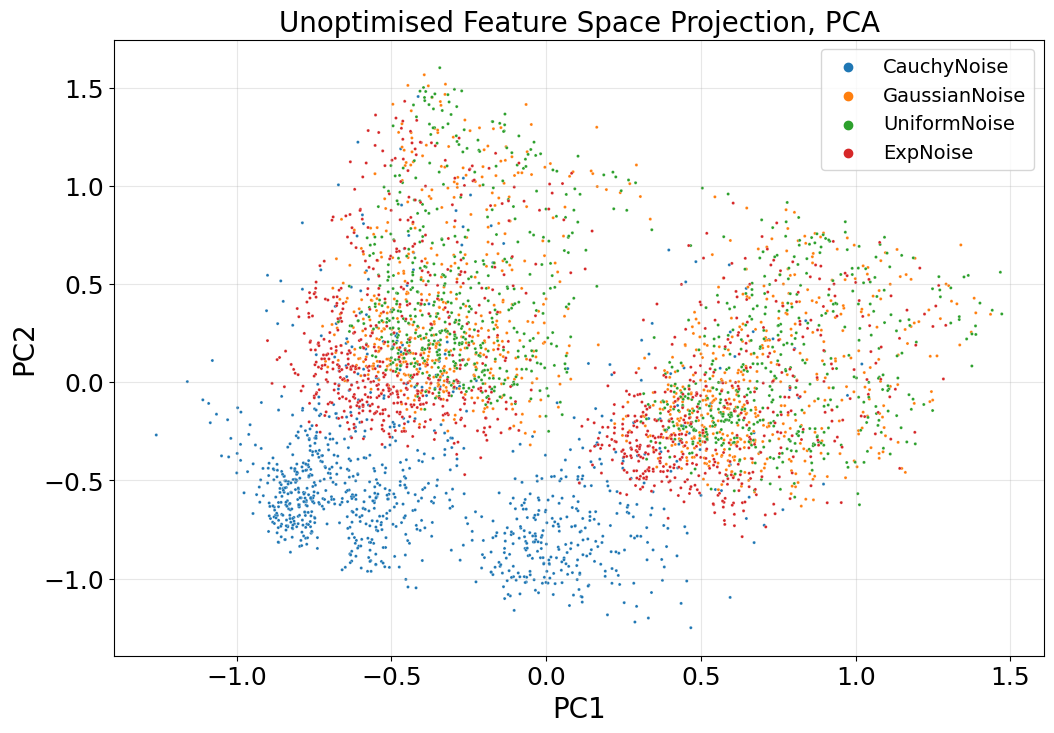

In [131]:
plt.figure(figsize=(12,8))
plt.grid(alpha=0.3)
sns.scatterplot(x=xhat_pca[:,0], y=xhat_pca[:,1], hue=df_all_noise['model'], s=5)
plt.legend(fontsize=14)
plt.title('Unoptimised Feature Space Projection, PCA', fontsize=20)
plt.xlabel('PC1', fontsize=20)
plt.ylabel('PC2', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

In [132]:
le = LabelEncoder().fit(df_all_noise['model'])
y = le.transform(df_all_noise['model'])

In [133]:
mmc = MMC_Supervised(random_state=634)
mmc_fit = mmc.fit(xhat, y)
X_mmc = mmc_fit.transform(xhat)
learned_metric = mmc.get_metric()

In [134]:
pca_opt = PCA(n_components=2)
pca_opt_fit = pca_opt.fit_transform(X_mmc)
#tsne_opt = TSNE(n_components=2, perplexity=30, random_state=25).fit_transform(pwise_dist)
#mds_opt = MDS(n_components=2, random_state=5445, dissimilarity='precomputed').fit_transform(pwise_dist)


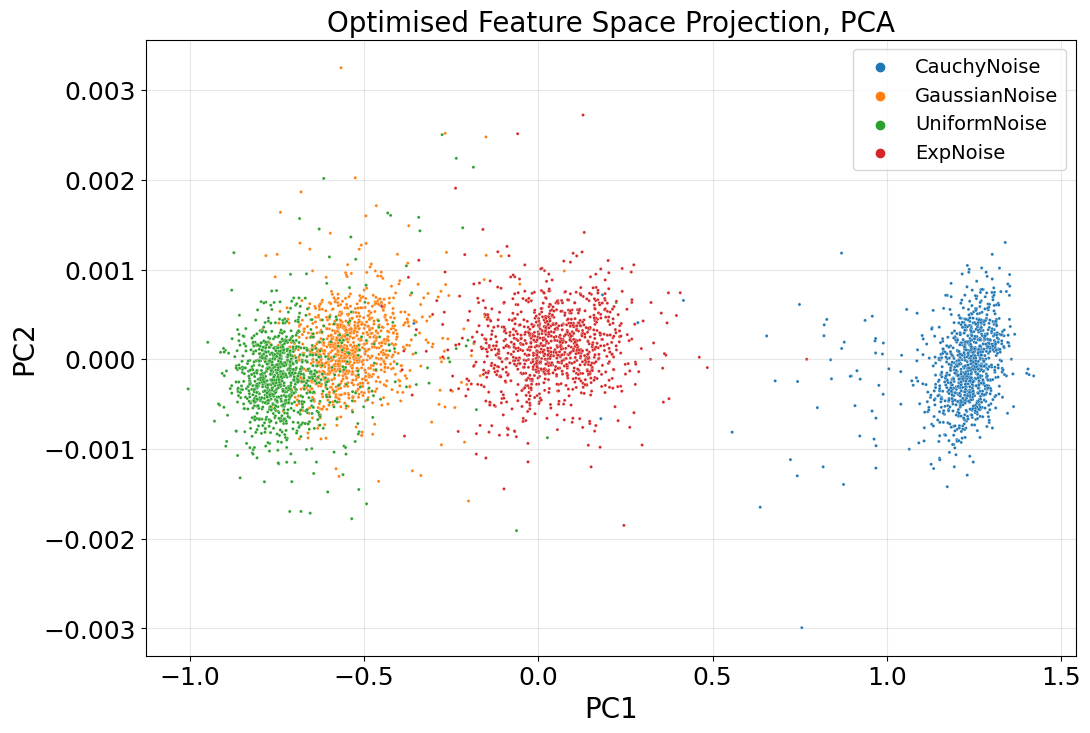

In [156]:
plt.figure(figsize=(12,8))
plt.grid(alpha=0.3)
sns.scatterplot(x=pca_opt_fit[:,0], y=pca_opt_fit[:,1], hue=df_all_noise['model'], s=5)
plt.xlabel('PC1', fontsize=20)
plt.ylabel('PC2', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Optimised Feature Space Projection, PCA', fontsize=20)
plt.legend(fontsize=14)
plt.show()

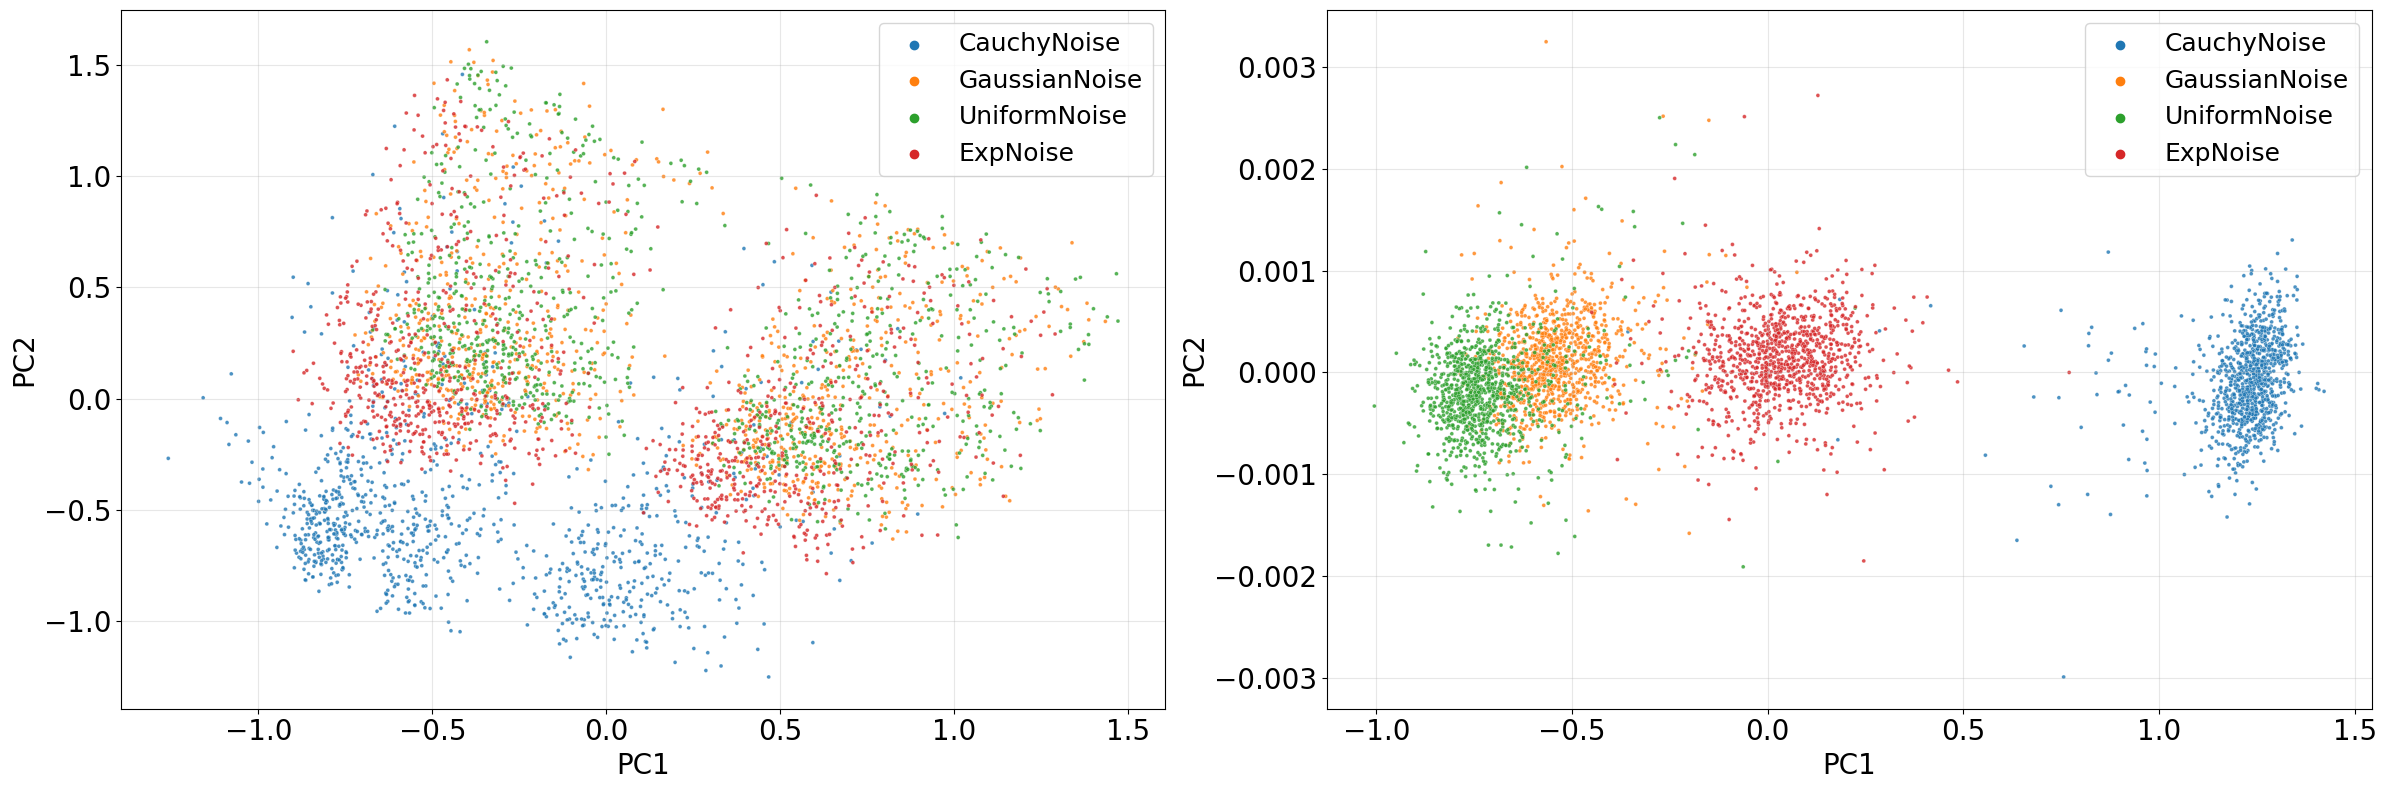

In [245]:
fig, ax = plt.subplots(1, 2, figsize=(24,8))
ax[0].grid(alpha=0.3)
ax[1].grid(alpha=0.3)
sns.scatterplot(x=pca_opt_fit[:,0], y=pca_opt_fit[:,1], hue=df_all_noise['model'], s=8, ax=ax[1], alpha=0.8)
sns.scatterplot(x=xhat_pca[:,0], y=xhat_pca[:,1], hue=df_all_noise['model'], s=8, ax=ax[0], alpha=0.8)
ax[1].set_xlabel('PC1', fontsize=20)
ax[1].set_ylabel('PC2', fontsize=20)
ax[0].set_xlabel('PC1', fontsize=20)
ax[0].set_ylabel('PC2', fontsize=20)
ax[1].legend(fontsize=18)
ax[0].legend(fontsize=18)
ax[1].tick_params(axis='both', which='major', labelsize=20)
ax[0].tick_params(axis='both', which='major', labelsize=20)
plt.tight_layout()
#plt.show()
plt.savefig('figures/metric_learning_projection.svg')

In [144]:
from sklearn.metrics import pairwise_distances

In [145]:
def within_between_class_distances(X, y):
    classes = np.unique(y)
    within_class_distances = []
    between_class_distances = []

    for i in range(len(classes)):
        class_i_data = X[y == classes[i]]
        for j in range(len(classes)):
            class_j_data = X[y == classes[j]]
            pairwise_distances_ij = pairwise_distances(class_i_data, class_j_data).flatten()
            if i == j:
                within_class_distances.append(pairwise_distances_ij)
            else:
                between_class_distances.append(pairwise_distances_ij)

    within_class_distances = np.hstack(within_class_distances)
    between_class_distances = np.hstack(between_class_distances)
    return within_class_distances, between_class_distances


compute pairwise distances before and after the transformation

In [146]:
within_class_distances_original, between_class_distances_original = within_between_class_distances(xhat, df_all_noise['model'])
within_class_distances_transformed, between_class_distances_transformed = within_between_class_distances(X_mmc, df_all_noise['model'])

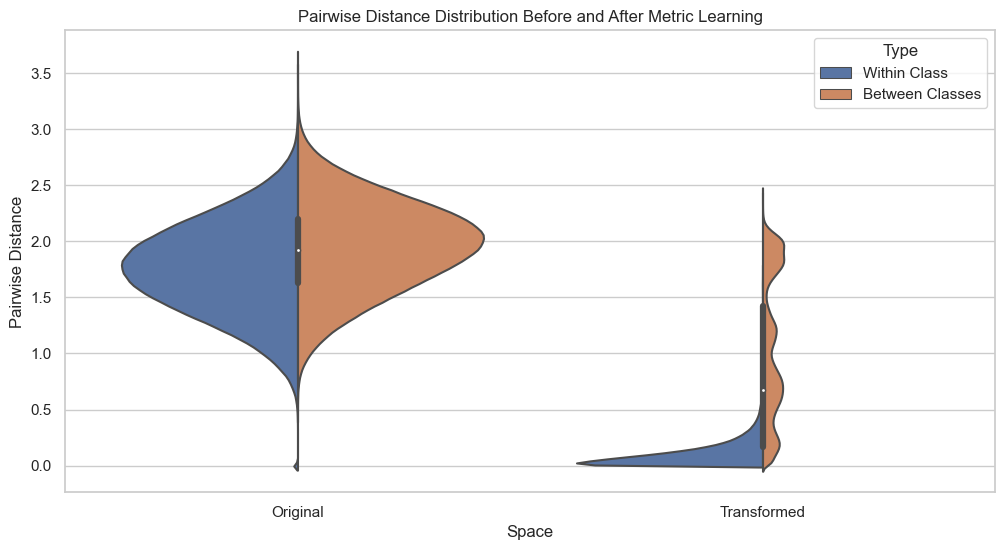

In [211]:
data_original = pd.DataFrame({
    "Pairwise Distance": np.hstack([within_class_distances_original, between_class_distances_original]),
    "Type": ["Within Class"] * len(within_class_distances_original) + ["Between Classes"] * len(between_class_distances_original),
    "Space": ["Original"] * (len(within_class_distances_original) + len(between_class_distances_original))
})

data_transformed = pd.DataFrame({
    "Pairwise Distance": np.hstack([within_class_distances_transformed, between_class_distances_transformed]),
    "Type": ["Within Class"] * len(within_class_distances_transformed) + ["Between Classes"] * len(between_class_distances_transformed),
    "Space": ["Transformed"] * (len(within_class_distances_transformed) + len(between_class_distances_transformed))
})

data = pd.concat([data_original, data_transformed])

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x="Space", y="Pairwise Distance", hue="Type", data=data, split=True)
plt.title("Pairwise Distance Distribution Before and After Metric Learning")
plt.show()

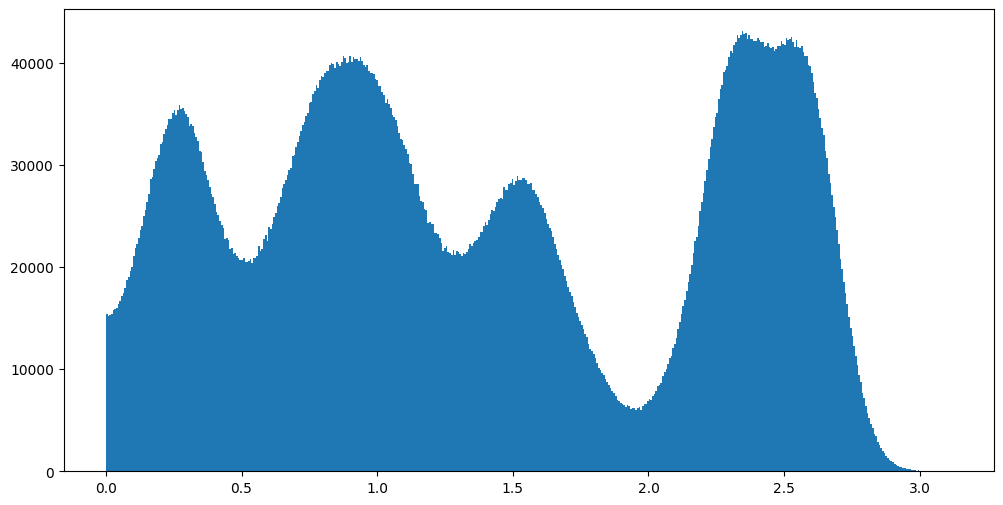

In [ ]:
plt.figure(figsize=(12, 6))
plt.hist(between_class_distances_transformed, bins=500)
plt.show()

In [ ]:
def individual_class_distances(X, y):
    classes = np.unique(y)
    class_distances = []

    for i in range(len(classes)):
        class_i_data = X[y == classes[i]]
        pairwise_distances_i = pairwise_distances(class_i_data).flatten()
        class_distances.append(pairwise_distances_i)

    return class_distances, classes

In [ ]:
class_distances_original, classes_original = individual_class_distances(xhat, df_all_noise['model'])
class_distances_transformed, classes_transformed = individual_class_distances(X_mmc, df_all_noise['model'])

In [ ]:
data_original = pd.DataFrame({
    "Pairwise Distance": np.hstack(class_distances_original),
    "Class": np.repeat(classes_original, [len(d) for d in class_distances_original]),
    "Space": ["Original"] * sum(len(d) for d in class_distances_original)
})

data_transformed = pd.DataFrame({
    "Pairwise Distance": np.hstack(class_distances_transformed),
    "Class": np.repeat(classes_transformed, [len(d) for d in class_distances_transformed]),
    "Space": ["Transformed"] * sum(len(d) for d in class_distances_transformed)
})

data = pd.concat([data_original, data_transformed])


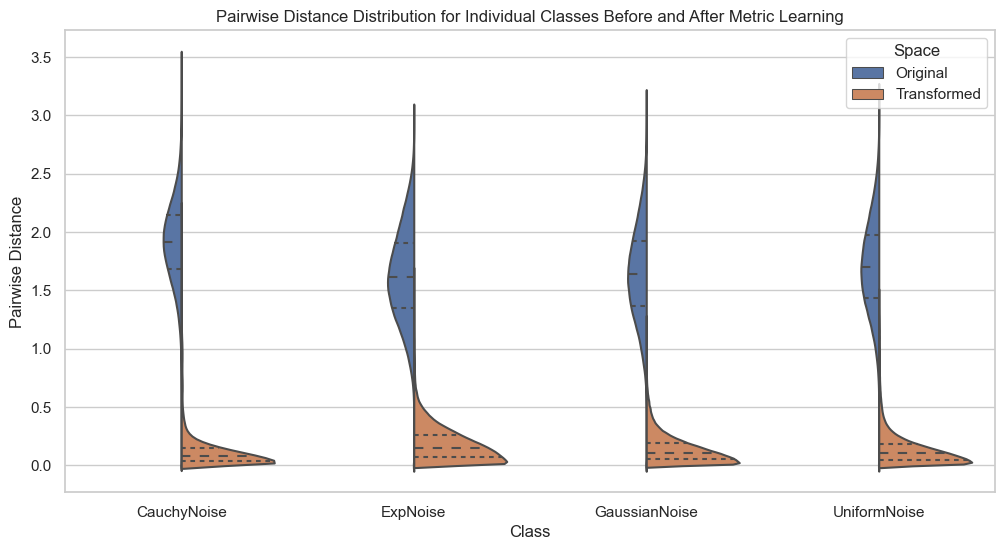

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x="Class", y="Pairwise Distance", hue="Space", data=data, split=True, inner="quartile")
plt.title("Pairwise Distance Distribution for Individual Classes Before and After Metric Learning")
plt.show()


In [ ]:
def between_class_distances(X, y):
    classes = np.unique(y)
    between_distances = []

    for i in range(len(classes)):
        class_i_data = X[y == classes[i]]
        for j in range(i + 1, len(classes)):
            class_j_data = X[y == classes[j]]
            pairwise_distances_ij = pairwise_distances(class_i_data, class_j_data).flatten()
            between_distances.append(pairwise_distances_ij)

    return between_distances, classes


In [ ]:
between_distances_original, classes_original = between_class_distances(xhat, df_all_noise['model'])
between_distances_transformed, classes_transformed = between_class_distances(X_mmc, df_all_noise['model'])


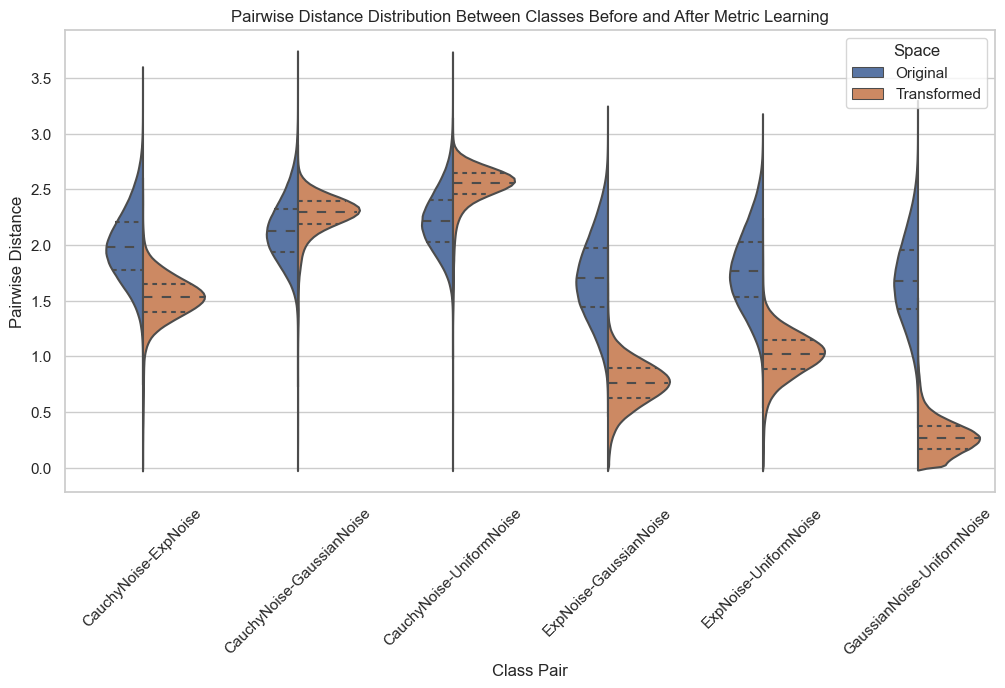

In [ ]:
class_pairs = [f'{i}-{j}' for i in classes_original for j in classes_original if i < j]

data_original = pd.DataFrame({
    "Pairwise Distance": np.hstack(between_distances_original),
    "Class Pair": np.repeat(class_pairs, [len(d) for d in between_distances_original]),
    "Space": ["Original"] * sum(len(d) for d in between_distances_original)
})

data_transformed = pd.DataFrame({
    "Pairwise Distance": np.hstack(between_distances_transformed),
    "Class Pair": np.repeat(class_pairs, [len(d) for d in between_distances_transformed]),
    "Space": ["Transformed"] * sum(len(d) for d in between_distances_transformed)
})

data = pd.concat([data_original, data_transformed])
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x="Class Pair", y="Pairwise Distance", hue="Space", data=data, split=True, inner="quartile")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.title("Pairwise Distance Distribution Between Classes Before and After Metric Learning")
plt.show()


Now let's analyse the transformation matrix to see what's going on. The transformation matrix rows represent the new axes in the transformed space and the columns represent the importance/weightings of the original features in each of these new axes. 

In [175]:
transformation_matrix = mmc.components_
feature_importance = np.sum(np.abs(transformation_matrix), axis=0)
total_importance = np.sum(feature_importance)
normalized_importance = feature_importance / total_importance
sorted_feature_importance = np.argsort(-feature_importance) # get indices of features in order from most important to least

In [176]:
sorted_feature_importance

array([ 6, 10,  4, 16, 12, 21, 13, 11, 15,  1,  9, 20,  2,  8,  0,  3, 14,
        7, 17, 19, 18,  5])

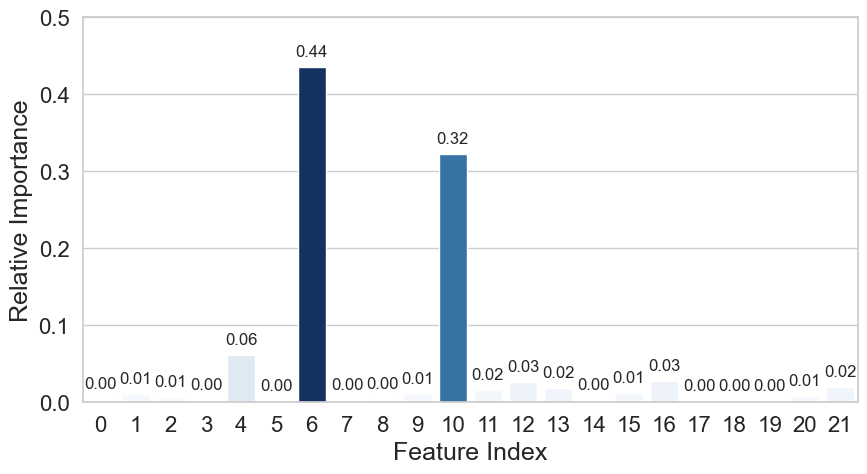

In [214]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

num_features = len(normalized_importance)
feature_indices = np.arange(num_features)

data = pd.DataFrame({'Feature Index': feature_indices, 'Normalized Importance': normalized_importance})

# Create a custom colormap based on the normalized importance
colors = plt.cm.Blues(normalized_importance / np.max(normalized_importance))

plt.figure(figsize=(10, 5))
sns.set(style="whitegrid")
bar_plot = sns.barplot(x='Feature Index', y='Normalized Importance', data=data, palette=colors)

# Add labels and title
plt.xlabel('Feature Index', fontsize=18)
plt.ylabel('Relative Importance', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.title('Normalized Importance of Features')
plt.ylim(0, 0.5)

# Add the feature index to each bar
for i, p in enumerate(bar_plot.patches):
    bar_plot.annotate(
        f"{normalized_importance[i]:.2f}",
        (p.get_x() + p.get_width() / 2.0, p.get_height() + 0.01),
        ha="center",
        va="bottom",
    )

plt.show()



Features 6 and 10 are the most important according to the transformation matrix weightings.

single-shot evaluation on the optimised space

In [202]:
ts_validate, df_validate = sample_noise(500, N=5000)
xhat_validate = mm.transform(sig.transform(rs.transform(df_validate.iloc[:,:22])))
y_validate = le.transform(df_validate['model'])

In [203]:
rnc = RadiusNeighborsClassifier(radius=0.1, outlier_label='most_frequent').fit(X_mmc, y)
Xhat_mmc = mmc.transform(xhat_validate)
y_pred = rnc.predict(Xhat_mmc)

In [204]:
radii = np.linspace(0.001, 0.015, 20)
logloss_val = list()
acc = list()
for r in radii:
    rnc = RadiusNeighborsClassifier(radius=r, outlier_label='most_frequent').fit(X_mmc, y)
    Xhat_mmc = mmc.transform(xhat_validate)
    y_pred = rnc.predict_proba(Xhat_mmc)
    logloss_val.append(log_loss(y_validate, y_pred))
    acc.append(rnc.score(Xhat_mmc, y_validate))

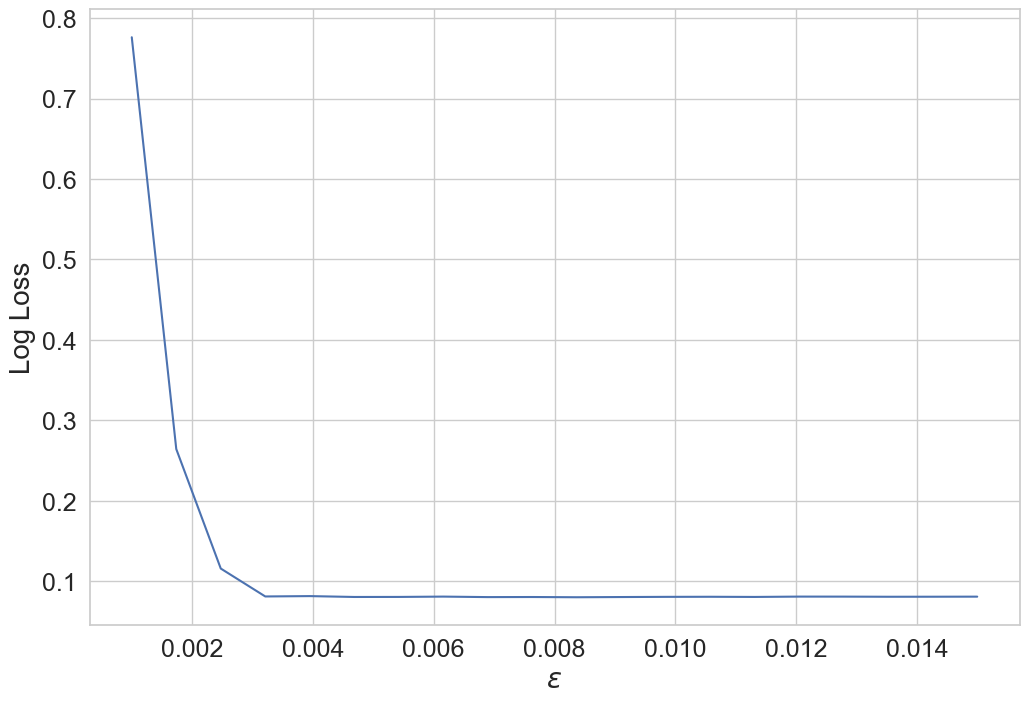

In [206]:
plt.figure(figsize=(12,8))
plt.plot(radii, logloss_val)
plt.xlabel(r'$\epsilon$', fontsize=20)
plt.ylabel('Log Loss', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#plt.plot(radii, acc)
plt.show()

In [207]:
np.min(logloss_val)

0.08007380599154484

In [208]:
radii = np.linspace(0.001, 1, 20)
logloss_val = list()
acc = list()
for r in radii:
    rnc = RadiusNeighborsClassifier(radius=r, outlier_label='most_frequent').fit(xhat, y)
    y_pred = rnc.predict_proba(xhat_validate)
    logloss_val.append(log_loss(y_validate, y_pred))
    acc.append(rnc.score(xhat_validate, y_validate))

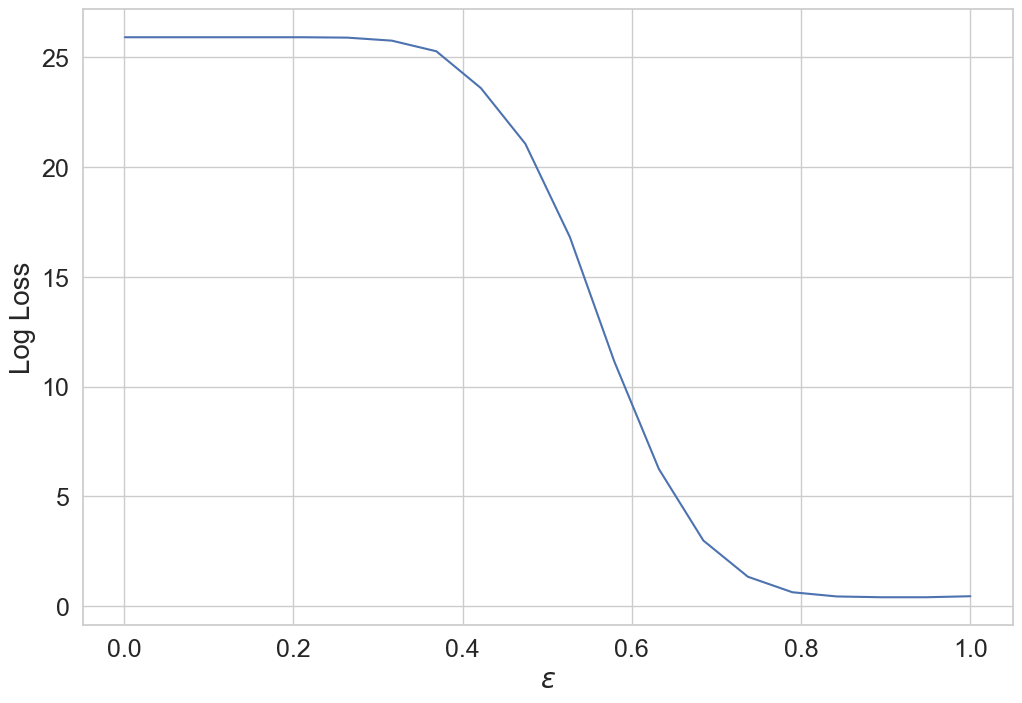

In [209]:
plt.figure(figsize=(12,8))
plt.plot(radii, logloss_val)
plt.xlabel(r'$\epsilon$', fontsize=20)
plt.ylabel('Log Loss', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#plt.plot(radii, acc)
plt.show()

In [210]:
np.min(logloss_val)

0.413400587184959

short vs long time series, 5-fold cv

In [ ]:
# train on 500, test on 125
n_folds = 5
radii = np.linspace(0.001, 0.01, 20)
logloss_val = list()
acc = list()
for f in range(n_folds):
    _, df_train = sample_noise(500, seed=np.random.randint(low=1, high=1000)) # create training data of all lengths
    _, df_test = sample_noise(125, N=5000, seed=np.random.randint(low=1, high=1000)) # test on fixed length
    rs = RobustScaler().fit(df_all_noise.iloc[:,:22])
    rs_transformed = rs.transform(df_all_noise.iloc[:,:22])
    def sigmoid(x, theta):
        return 1/(1+np.exp(-theta*x))
    sig = FunctionTransformer(sigmoid, kw_args={'theta': 1.35})
    sig_transformed = sig.transform(rs_transformed)
    mm = MinMaxScaler().fit(sig_transformed)
    mm_transformed = mm.transform(sig_transformed)
    xhat_train = mm_transformed
    xhat_test = mm.transform(sig.transform(rs.transform(df_test.iloc[:,:22])))
    le = LabelEncoder().fit(df_train['model'])
    y_train = le.transform(df_train['model'])
    y_test = le.transform(df_test['model'])
    # optimise space using metric learning, fix seed for reproducibility
    mmc = MMC_Supervised(random_state=12)
    mmc_fit = mmc.fit(xhat_train, y_train)
    X_mmc_train = mmc_fit.transform(xhat_train)
    X_mmc_test = mmc_fit.transform(xhat_test)
    # train classifier
    store_fold_logloss = list()
    store_fold_acc = list()
    for r in radii:
        rnc = RadiusNeighborsClassifier(radius=r, outlier_label='most_frequent').fit(X_mmc_train, y_train)
        y_pred = rnc.predict_proba(X_mmc_test)
        store_fold_logloss.append(log_loss(y_test, y_pred))
        store_fold_acc.append(rnc.score(X_mmc_test, y_test))
    logloss_val.append(store_fold_logloss)
    acc.append(store_fold_acc)
    

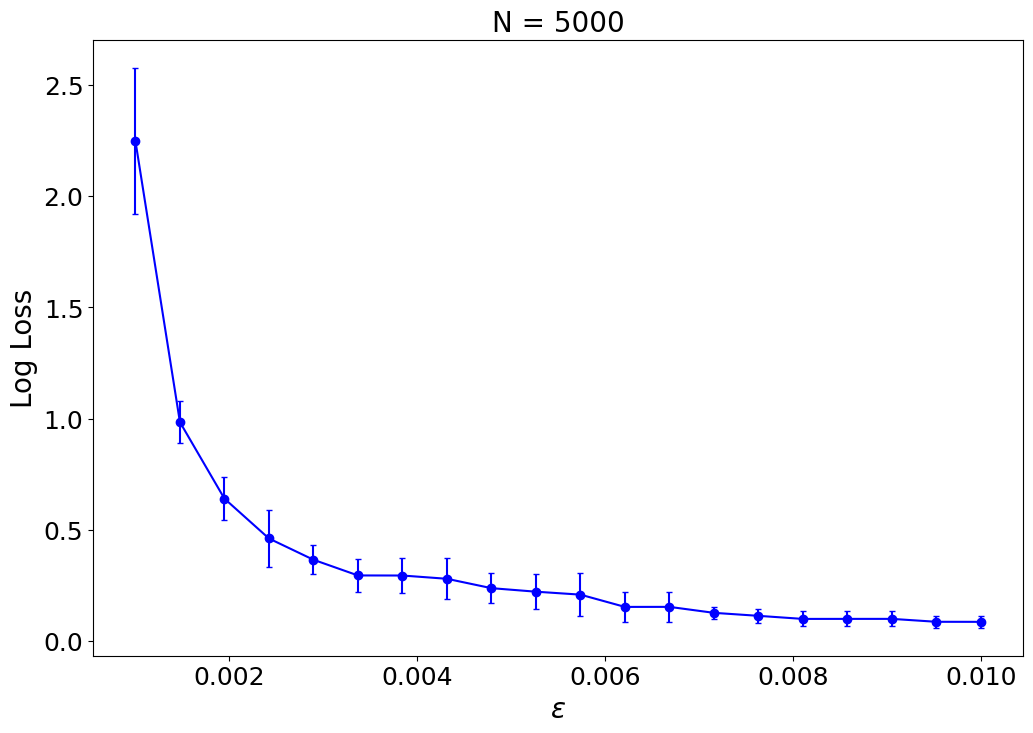

In [ ]:
plt.figure(figsize=(12,8))
plt.title('N = 5000', fontsize=20)
plt.plot(radii, np.mean(logloss_val, axis=0), c='b')
plt.errorbar(radii, np.mean(logloss_val, axis=0), yerr=np.std(logloss_val, axis=0), capsize=2, fmt='o', c='b')
plt.xlabel(r'$\epsilon$', fontsize=20)
plt.ylabel('Log Loss', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

### Gaussian vs Cauchy Noise

In [ ]:
ts_gauss, df_gauss = sample_gaussianNoise(n_samples=500)
ts_cauchy, df_cauchy = sample_cauchyNoise(n_samples=500)
df_combined = pd.concat([df_gauss, df_cauchy], axis=0, ignore_index=True)

In [ ]:
rs = RobustScaler().fit(df_combined.iloc[:,:22])
rs_transformed = rs.transform(df_combined.iloc[:,:22])
def sigmoid(x, theta):
    return 1/(1+np.exp(-theta*x))
sig = FunctionTransformer(sigmoid, kw_args={'theta': 1.35})
sig_transformed = sig.transform(rs_transformed)
mm = MinMaxScaler().fit(sig_transformed)
mm_transformed = mm.transform(sig_transformed)
xhat = mm_transformed
pca = PCA(n_components=2).fit(xhat)
xhat_pca = pca.transform(xhat)

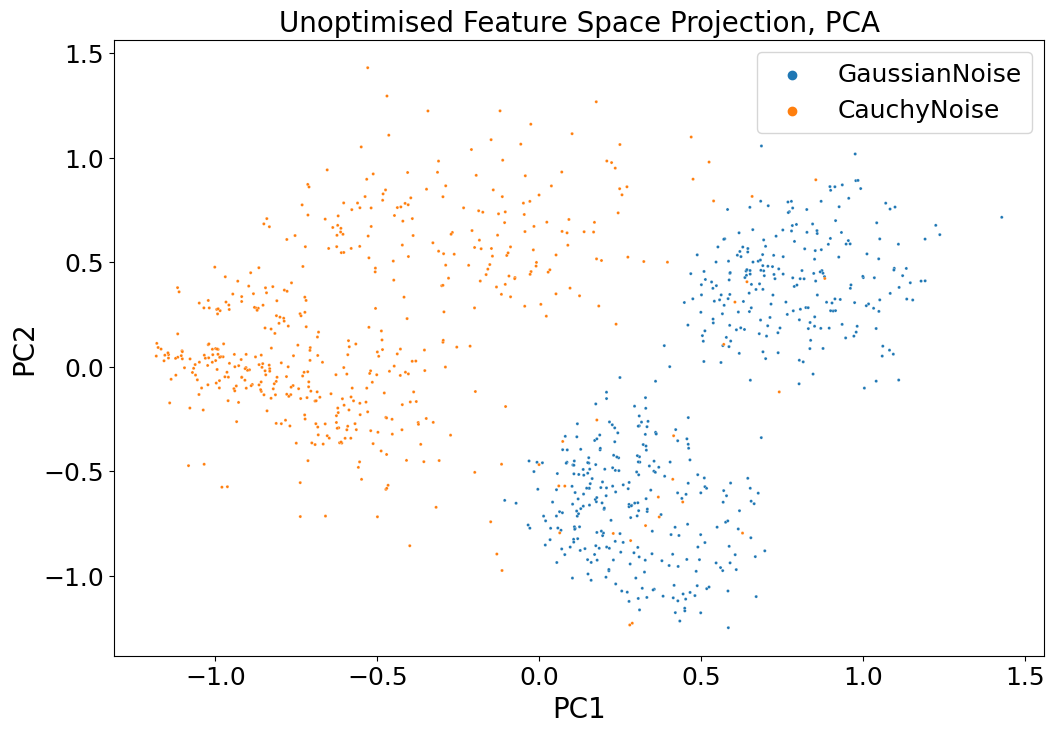

In [ ]:
plt.figure(figsize=(12,8))
sns.scatterplot(x=xhat_pca[:,0], y=xhat_pca[:,1], hue=df_combined['model'], s=5)
plt.title('Unoptimised Feature Space Projection, PCA', fontsize=20)
plt.xlabel('PC1', fontsize=20)
plt.ylabel('PC2', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.show()

In [ ]:
le = LabelEncoder().fit(df_combined['model'])
y = le.transform(df_combined['model'])

In [ ]:
mmc = MMC_Supervised(random_state=25)
mmc_fit = mmc.fit(xhat, y)
X_mmc = mmc_fit.transform(xhat)
learned_metric = mmc.get_metric()

In [ ]:
pca_opt = PCA(n_components=2).fit(X_mmc)
X_mmc_pca = pca_opt.transform(X_mmc)

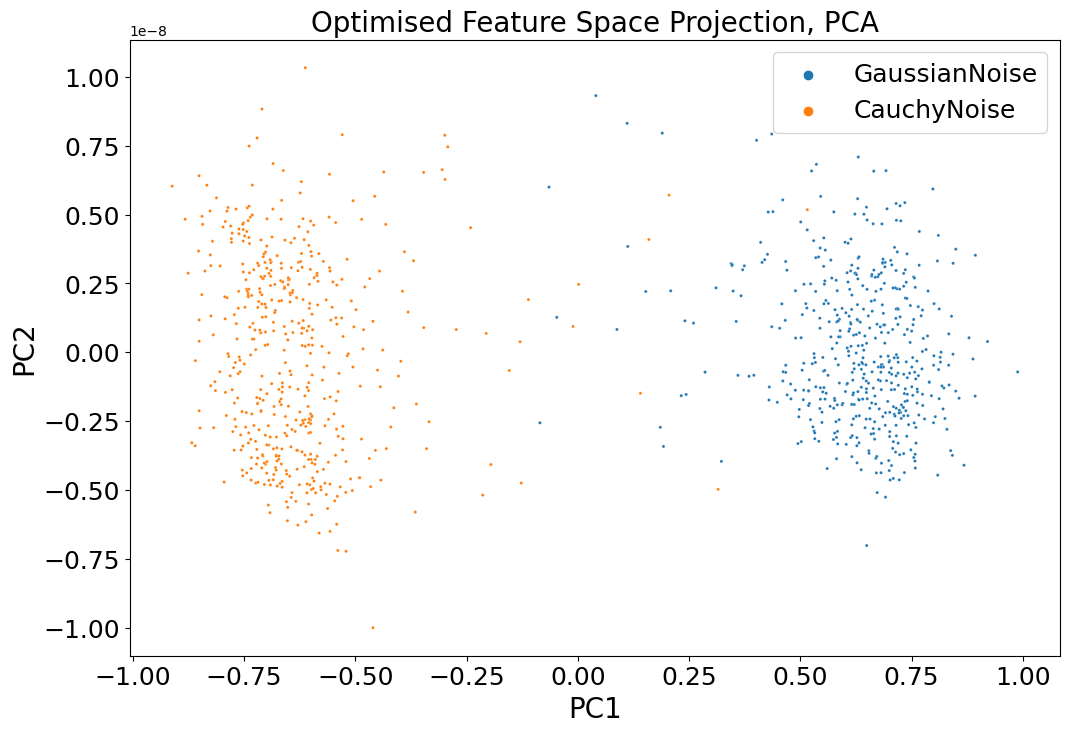

In [ ]:
plt.figure(figsize=(12,8))
sns.scatterplot(x=X_mmc_pca[:,0], y=X_mmc_pca[:,1], hue=df_combined['model'], s=5)
plt.title('Optimised Feature Space Projection, PCA', fontsize=20)
plt.xlabel('PC1', fontsize=20)
plt.ylabel('PC2', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.show()

## Chaotic Maps vs Noise

Generate data from chaotic and stochastic metamodels

In [ ]:
ts_maps, df_maps = sample_Maps(samples_per_map=200)
ts_noise, df_noise = sample_noise(550)

In [ ]:
df_combined = pd.concat([df_maps, df_noise], axis=0, ignore_index=True)

In [ ]:
rs = RobustScaler().fit(df_combined.iloc[:,:22])
rs_transformed = rs.transform(df_combined.iloc[:,:22])
def sigmoid(x, theta):
    return 1/(1+np.exp(-theta*x))
sig = FunctionTransformer(sigmoid, kw_args={'theta': 1.35})
sig_transformed = sig.transform(rs_transformed)
mm = MinMaxScaler().fit(sig_transformed)
mm_transformed = mm.transform(sig_transformed)
xhat = mm_transformed
pca = PCA(n_components=2).fit(xhat)
xhat_pca = pca.transform(xhat)

In [ ]:
xhat_tsne = TSNE(n_components=2, perplexity=100, random_state=42).fit_transform(xhat)
xhat_mds = MDS(n_components=2, random_state=42).fit_transform(xhat)

/Users/joshua/opt/anaconda3/envs/isa/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/joshua/opt/anaconda3/envs/isa/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


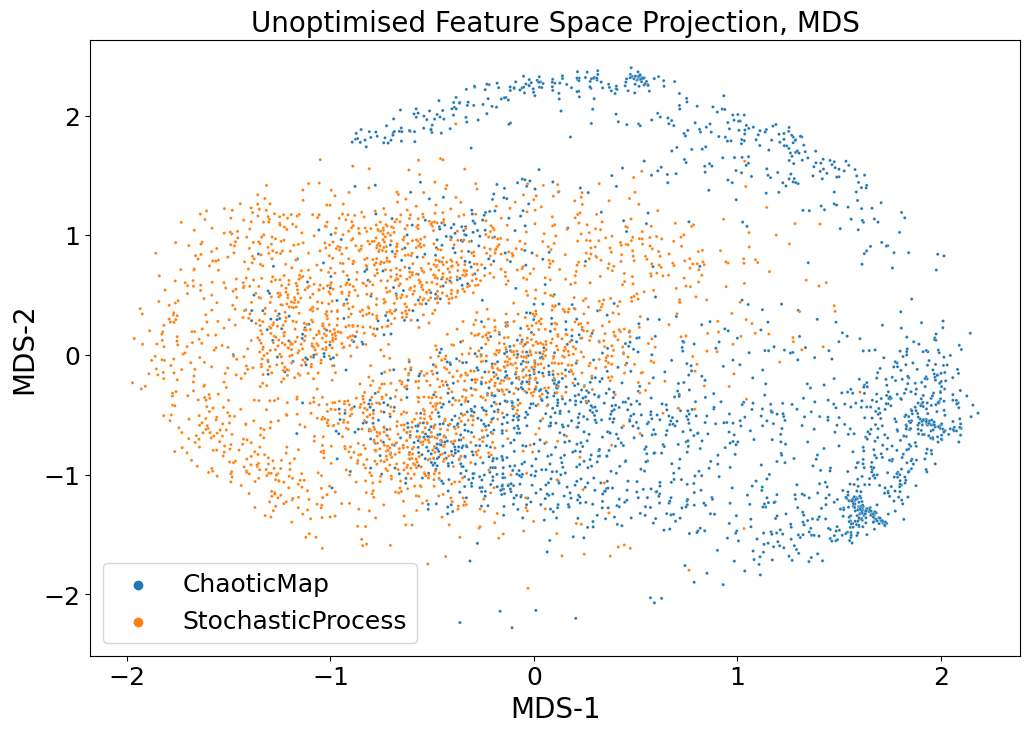

In [ ]:
plt.figure(figsize=(12,8))
sns.scatterplot(x=xhat_mds[:,0], y=xhat_mds[:,1], hue=df_combined['metaModel'], s=5)
plt.title('Unoptimised Feature Space Projection, MDS', fontsize=20)
plt.xlabel('MDS-1', fontsize=20)
plt.ylabel('MDS-2', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.show()

## Performance Evaluation

In [ ]:
ts_maps_eval, df_maps_eval = sample_Maps(samples_per_map=40)
ts_noise_eval, df_noise_eval = sample_noise(110)

In [ ]:
df_eval = pd.concat([df_maps_eval, df_noise_eval], axis=0, ignore_index=True)

In [ ]:
x_hat_eval = mm.transform(sig.transform(rs.transform(df_eval.iloc[:,:22])))

In [ ]:
radii = np.linspace(0.5, 1.5, 30)
log_loss_values = list()
scores = list()
for radius in radii:
    rnc_optimised = RadiusNeighborsClassifier(radius=radius, outlier_label='most_frequent')
    rnc_optimised.fit(xhat, df_combined['metaModel'])
    y_pred = rnc_optimised.predict_proba(x_hat_eval)
    log_loss_value = log_loss(df_eval['metaModel'], y_pred)
    score = rnc_optimised.score(x_hat_eval, df_eval['metaModel'])
    log_loss_values.append(log_loss_value)
    scores.append(score)

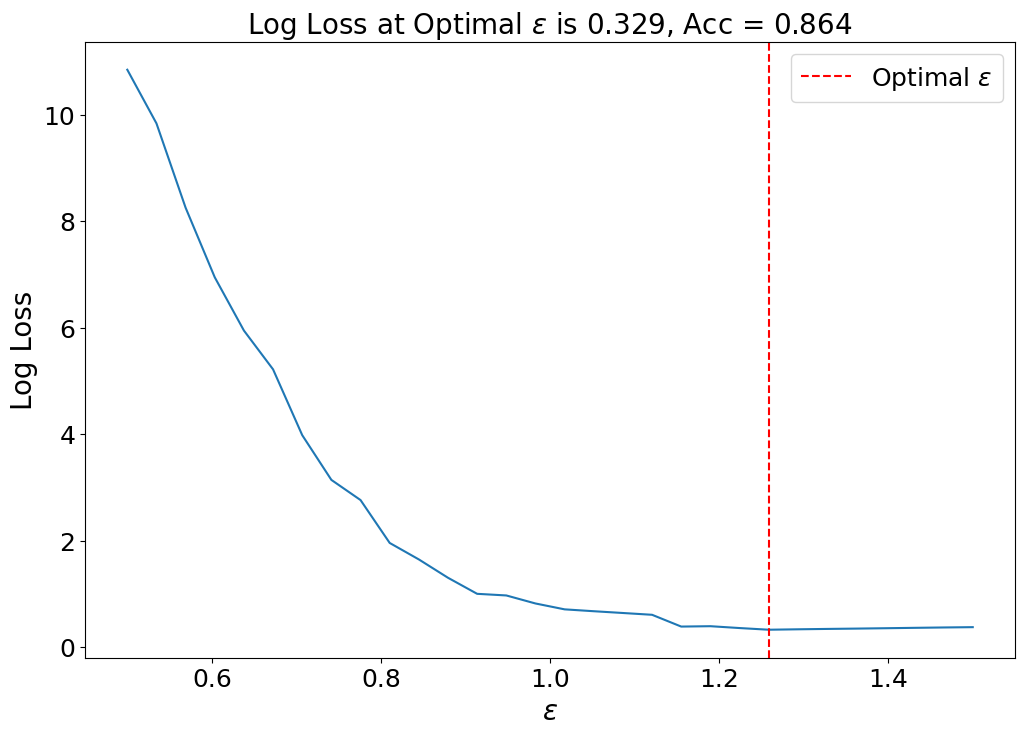

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(radii, log_loss_values)
plt.xlabel('$\epsilon$', fontsize=20)
plt.ylabel('Log Loss', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.axvline(x=radii[np.argmin(log_loss_values)], color='r', linestyle='--', label='Optimal $\epsilon$')
plt.title(f'Log Loss at Optimal $\epsilon$ is {np.min(log_loss_values):.3f}, Acc = {scores[np.argmin(log_loss_values)]:.3f}', fontsize=20)
plt.legend(fontsize=18)
plt.show()

In [ ]:
le = LabelEncoder().fit(df_combined['metaModel'])
y = le.transform(df_combined['metaModel'])

In [ ]:
mmc = MMC_Supervised(random_state=25)
mmc_fit = mmc.fit(xhat, y)
X_mmc = mmc_fit.transform(xhat)
learned_metric = mmc.get_metric()

In [ ]:
pwise_dist = cdist(X_mmc, X_mmc, metric=learned_metric)

In [ ]:
mds_opt = MDS(n_components=2, random_state=42, dissimilarity='precomputed').fit_transform(pwise_dist)
pca_opt = PCA(n_components=2).fit_transform(X_mmc)


In [ ]:
tsne_opt = TSNE(n_components=2, perplexity=100, random_state=34, metric='precomputed').fit_transform(pwise_dist)

/Users/joshua/opt/anaconda3/envs/isa/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/joshua/opt/anaconda3/envs/isa/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


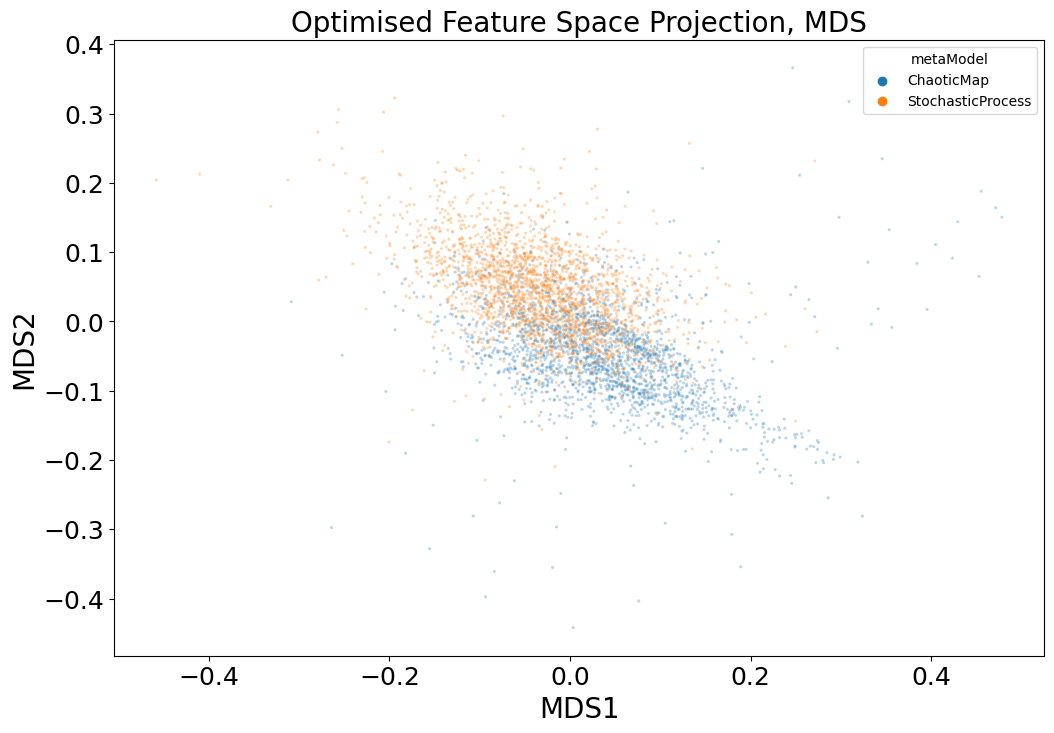

In [ ]:
plt.figure(figsize=(12,8))
sns.scatterplot(x=mds_opt[:,0], y=mds_opt[:,1], hue=df_combined['metaModel'], s=5, alpha=0.3)
plt.title('Optimised Feature Space Projection, MDS', fontsize=20)
plt.xlabel('MDS1', fontsize=20)
plt.ylabel('MDS2', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

save data as matlab file

In [ ]:
basename = 'stochastic'
labels = ["{}_{}.dat".format(basename, i) for i in range(len(ts_noise))]

In [ ]:
labels = np.array(labels, dtype='object')
keywords = np.tile('stochastic', len(ts_noise))
keywords = np.array(keywords, dtype='object')
timeSeriesData = np.array(ts_noise, dtype='object')

In [ ]:
from scipy.io import savemat
mdic = {"timeSeriesData": timeSeriesData, "labels": labels, "keywords": keywords}
savemat("INP_stochastic_ts.mat", mdic)

import matlab file from hctsa

In [ ]:
from scipy.io import loadmat

In [ ]:
chaos = loadmat('HCTSA_chaos.mat')
noise = loadmat('HCTSA_stochastic.mat')

In [ ]:
chaos_featVect = chaos['TS_DataMat']
noise_featVect = noise['TS_DataMat']

In [ ]:
df_additional = pd.DataFrame(np.concatenate([chaos_featVect, noise_featVect], axis=0))

In [ ]:
df_augmented = pd.concat([df_additional, df_combined], axis=1, ignore_index=True)

In [ ]:
df_augmented.head()

0         1    2    3    4         5    6         7         8    9   ...  \
0  0.0 -0.685825  0.0  0.0  0.0 -0.010676  0.0  0.374315  0.009727  0.0  ...   
1  0.0 -1.770887  0.0  0.0  0.0 -0.071001  0.0  0.112200  0.037793  0.0  ...   
2  0.0 -0.257057  0.0  0.0  0.0 -0.008780  0.0  0.160223 -0.003379  0.0  ...   
3  0.0 -0.937276  0.0  0.0  0.0 -0.076687  0.0  0.147876 -0.005456  0.0  ...   
4  0.0 -1.254671  0.0  0.0  0.0 -0.073403  0.0  0.122865  0.028254  0.0  ...   

         35        36        37        38        39    40        41        42  \
0  1.927252  0.122449  0.510204  3.141593  1.284575  1941  1.057847  0.420594   
1  2.138752  0.877551  0.632653  2.150641  1.220060  3103  1.343901  0.486748   
2  2.064523  0.857143  0.448980  3.071030  1.250228  4237  1.088169  0.733954   
3  2.126519  0.340909  0.136364  2.368466  1.237415   309  1.207433  0.514575   
4  2.119684  0.854167  0.125000  2.346991  1.222677  1452  1.212030  0.536566   

         43          44  
0  HenonMap  ChaoticMap  
1  HenonMap  ChaoticMap  
2  HenonMap  ChaoticMap  
3  HenonMap  ChaoticMap  
4  HenonMap  ChaoticMap  

[5 rows x 45 columns]

In [ ]:
df_augmented.shape

(4400, 45)

In [ ]:
rs = RobustScaler().fit(df_augmented.iloc[:,:39])
rs_transformed = rs.transform(df_augmented.iloc[:,:39])
def sigmoid(x, theta):
    return 1/(1+np.exp(-theta*x))
sig = FunctionTransformer(sigmoid, kw_args={'theta': 1.35})
sig_transformed = sig.transform(rs_transformed)
mm = MinMaxScaler().fit(sig_transformed)
mm_transformed = mm.transform(sig_transformed)
xhat = mm_transformed
pca = PCA(n_components=2).fit(xhat)
xhat_pca = pca.transform(xhat)

In [ ]:
xhat_tsne = TSNE(n_components=2, perplexity=100, random_state=34).fit_transform(xhat)
xhat_mds = MDS(n_components=2, random_state=42).fit_transform(xhat)

/Users/joshua/opt/anaconda3/envs/isa/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/joshua/opt/anaconda3/envs/isa/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


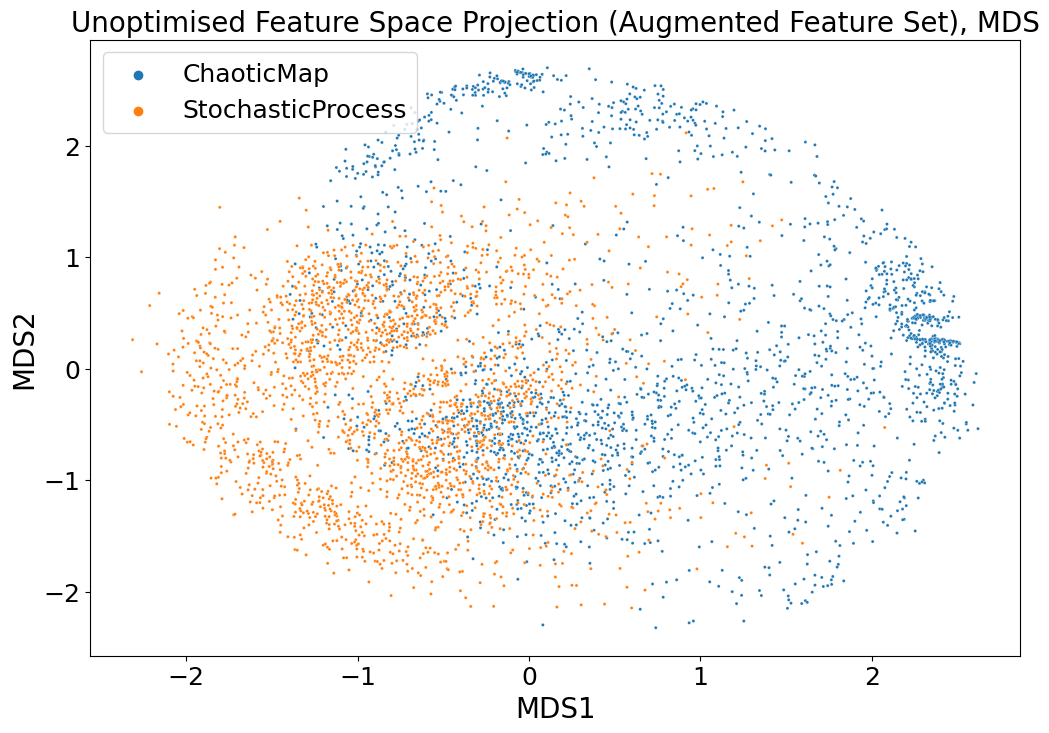

In [ ]:
plt.figure(figsize=(12,8))
sns.scatterplot(x=xhat_mds[:,0], y=xhat_mds[:,1], hue=df_combined['metaModel'], s=5)
plt.title('Unoptimised Feature Space Projection (Augmented Feature Set), MDS', fontsize=20)
plt.xlabel('MDS1', fontsize=20)
plt.ylabel('MDS2', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.show()

In [ ]:
le = LabelEncoder().fit(df_augmented.iloc[:,44])
y = le.transform(df_augmented.iloc[:,44])

In [ ]:
mmc = MMC_Supervised(random_state=3453)
mmc_fit = mmc.fit(xhat, y)
X_mmc = mmc_fit.transform(xhat)
learned_metric = mmc.get_metric()

In [ ]:
pwise_dist = cdist(X_mmc, X_mmc, metric=learned_metric)

In [ ]:
pca_opt = PCA(n_components=2).fit_transform(X_mmc)

In [ ]:
mds_opt = MDS(n_components=2, random_state=5445, dissimilarity='precomputed').fit_transform(pwise_dist)

In [ ]:
tsne_opt = TSNE(n_components=2, random_state=245, perplexity=100, metric='precomputed').fit_transform(pwise_dist)

/Users/joshua/opt/anaconda3/envs/isa/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/joshua/opt/anaconda3/envs/isa/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


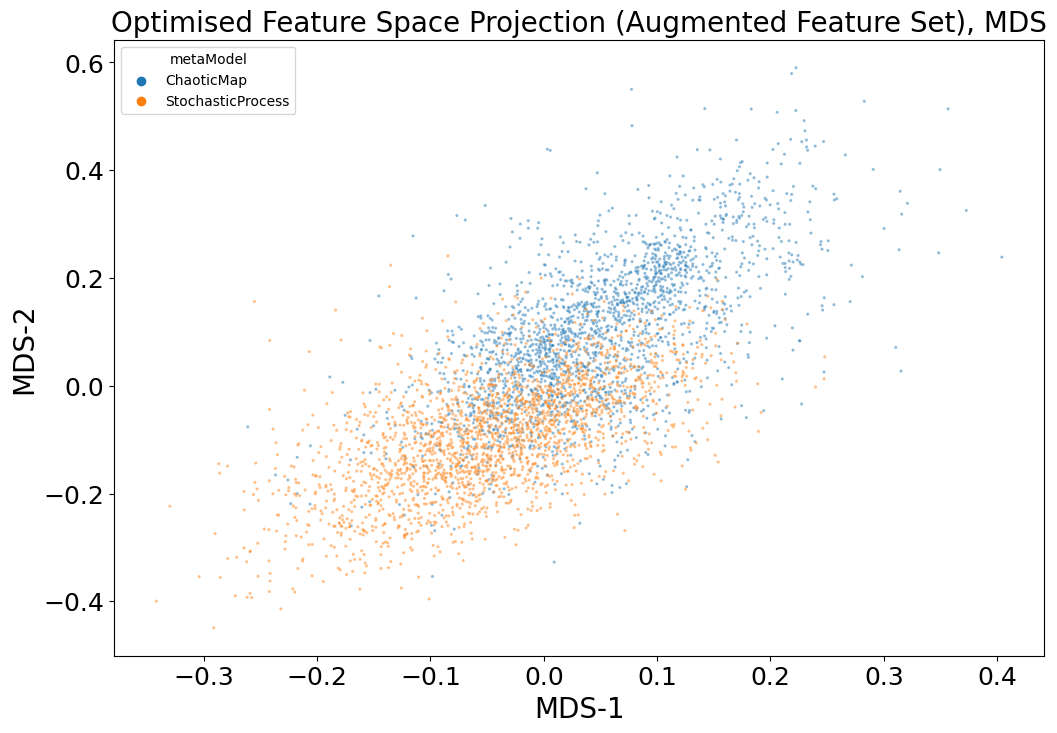

In [ ]:
plt.figure(figsize=(12,8))
sns.scatterplot(x=mds_opt[:,0], y=mds_opt[:,1], hue=df_combined['metaModel'], s=5, alpha=0.5)
plt.xlabel('MDS-1', fontsize=20)
plt.ylabel('MDS-2', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Optimised Feature Space Projection (Augmented Feature Set), MDS', fontsize=20)
plt.show()

## Chaos vs Gaussian Noise

In [ ]:
ts_maps2, df_maps2 = sample_Maps(100)
ts_noise2, df_noise2 = sample_gaussianNoise(1100)

In [ ]:
df_chaos_v_noise = pd.concat([df_maps2, df_noise2], axis=0, ignore_index=True)

In [ ]:
rs = RobustScaler().fit(df_chaos_v_noise.iloc[:,:22])
rs_transformed = rs.transform(df_chaos_v_noise.iloc[:,:22])
def sigmoid(x, theta):
    return 1/(1+np.exp(-theta*x))
sig = FunctionTransformer(sigmoid, kw_args={'theta': 1.35})
sig_transformed = sig.transform(rs_transformed)
mm = MinMaxScaler().fit(sig_transformed)
mm_transformed = mm.transform(sig_transformed)
xhat = mm_transformed
pca = PCA(n_components=2).fit(xhat)
xhat_pca = pca.transform(xhat)

<AxesSubplot: >

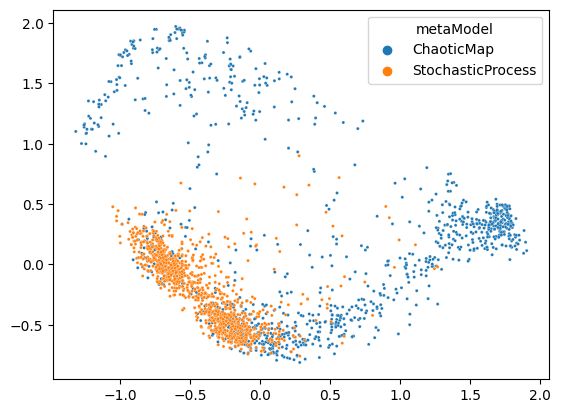

In [ ]:
sns.scatterplot(x=xhat_pca[:,0], y=xhat_pca[:,1], hue=df_chaos_v_noise['metaModel'], s=5)

## Evaluation II

In [246]:
ts_all_noise_2, df_all_noise_2 = sample_noise(10000)

In [247]:
rs2 = RobustScaler().fit(df_all_noise_2.iloc[:,:22])
rs_transformed2 = rs2.transform(df_all_noise_2.iloc[:,:22])
def sigmoid(x, theta):
    return 1/(1+np.exp(-theta*x))
sig2 = FunctionTransformer(sigmoid, kw_args={'theta': 1.35})
sig_transformed2 = sig.transform(rs_transformed2)
mm2 = MinMaxScaler().fit(sig_transformed2)
mm_transformed2 = mm2.transform(sig_transformed2)
xhat2 = mm_transformed2
pca2 = PCA(n_components=2).fit(xhat2)
xhat_pca2 = pca2.transform(xhat2)

In [251]:
le2 = LabelEncoder().fit(df_all_noise_2['model'])
y2 = le2.transform(df_all_noise_2['model'])
mmc2 = MMC_Supervised(random_state=634)
mmc_fit2 = mmc2.fit(xhat2, y2)
X_mmc2 = mmc_fit2.transform(xhat2)
learned_metric2 = mmc2.get_metric()

In [252]:
pca_opt2 = PCA(n_components=2)
pca_opt_fit2 = pca_opt2.fit_transform(X_mmc2)

<AxesSubplot: >

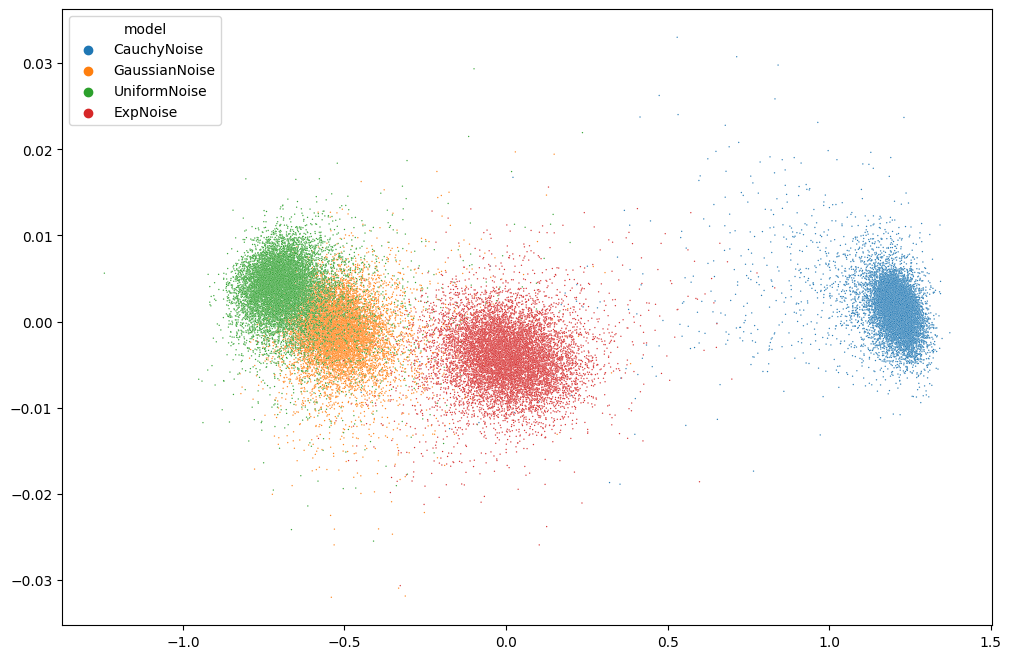

In [255]:
plt.figure(figsize=(12,8))
sns.scatterplot(x=pca_opt_fit2[:,0], y=pca_opt_fit2[:,1], hue=df_all_noise_2['model'], s=1)


calibrate